# House Rent Prediction - Full Data Science Pipeline

This notebook demonstrates the complete workflow for predicting house rent prices using Linear Regression.


In [69]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

import warnings
warnings.filterwarnings('ignore')


## 1. Data Loading & Exploration


In [70]:
# Load raw data
df_raw = pd.read_csv("Data/rent.csv")
print(f"Dataset shape: {df_raw.shape}")
print(f"\nColumns: {list(df_raw.columns)}")
df_raw.head()


Dataset shape: (4746, 12)

Columns: ['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [71]:
# Data types and missing values
print("Data Types:")
print(df_raw.dtypes)
print(f"\nMissing Values:\n{df_raw.isnull().sum()}")


Data Types:
Posted On            object
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
dtype: object

Missing Values:
Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64


### 1.1 Target Variable Distribution (Rent)


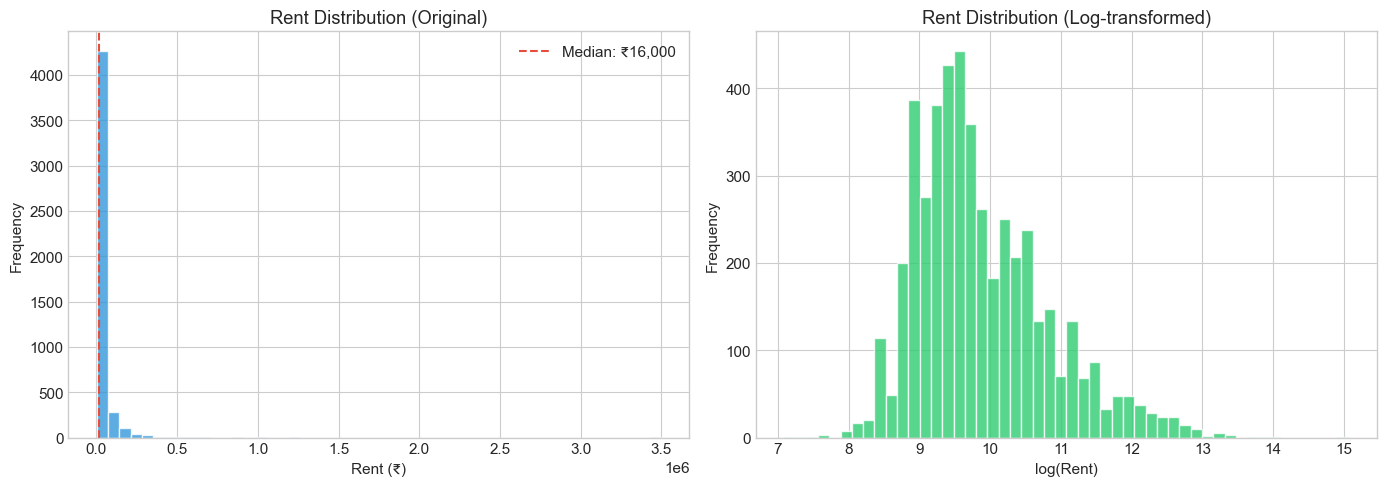

Rent Statistics:
  Min: ₹1,200
  Max: ₹3,500,000
  Mean: ₹34,993
  Median: ₹16,000


In [72]:
# Rent distribution - before and after log transform
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
axes[0].hist(df_raw['Rent'], bins=50, color='#3498db', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Rent (₹)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Rent Distribution (Original)')
axes[0].axvline(df_raw['Rent'].median(), color='#e74c3c', linestyle='--', label=f"Median: ₹{df_raw['Rent'].median():,.0f}")
axes[0].legend()

# Log-transformed distribution
axes[1].hist(np.log(df_raw['Rent']), bins=50, color='#2ecc71', edgecolor='white', alpha=0.8)
axes[1].set_xlabel('log(Rent)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Rent Distribution (Log-transformed)')

plt.tight_layout()
plt.show()

print(f"Rent Statistics:")
print(f"  Min: ₹{df_raw['Rent'].min():,}")
print(f"  Max: ₹{df_raw['Rent'].max():,}")
print(f"  Mean: ₹{df_raw['Rent'].mean():,.0f}")
print(f"  Median: ₹{df_raw['Rent'].median():,.0f}")


### 1.2 Categorical Features Distribution


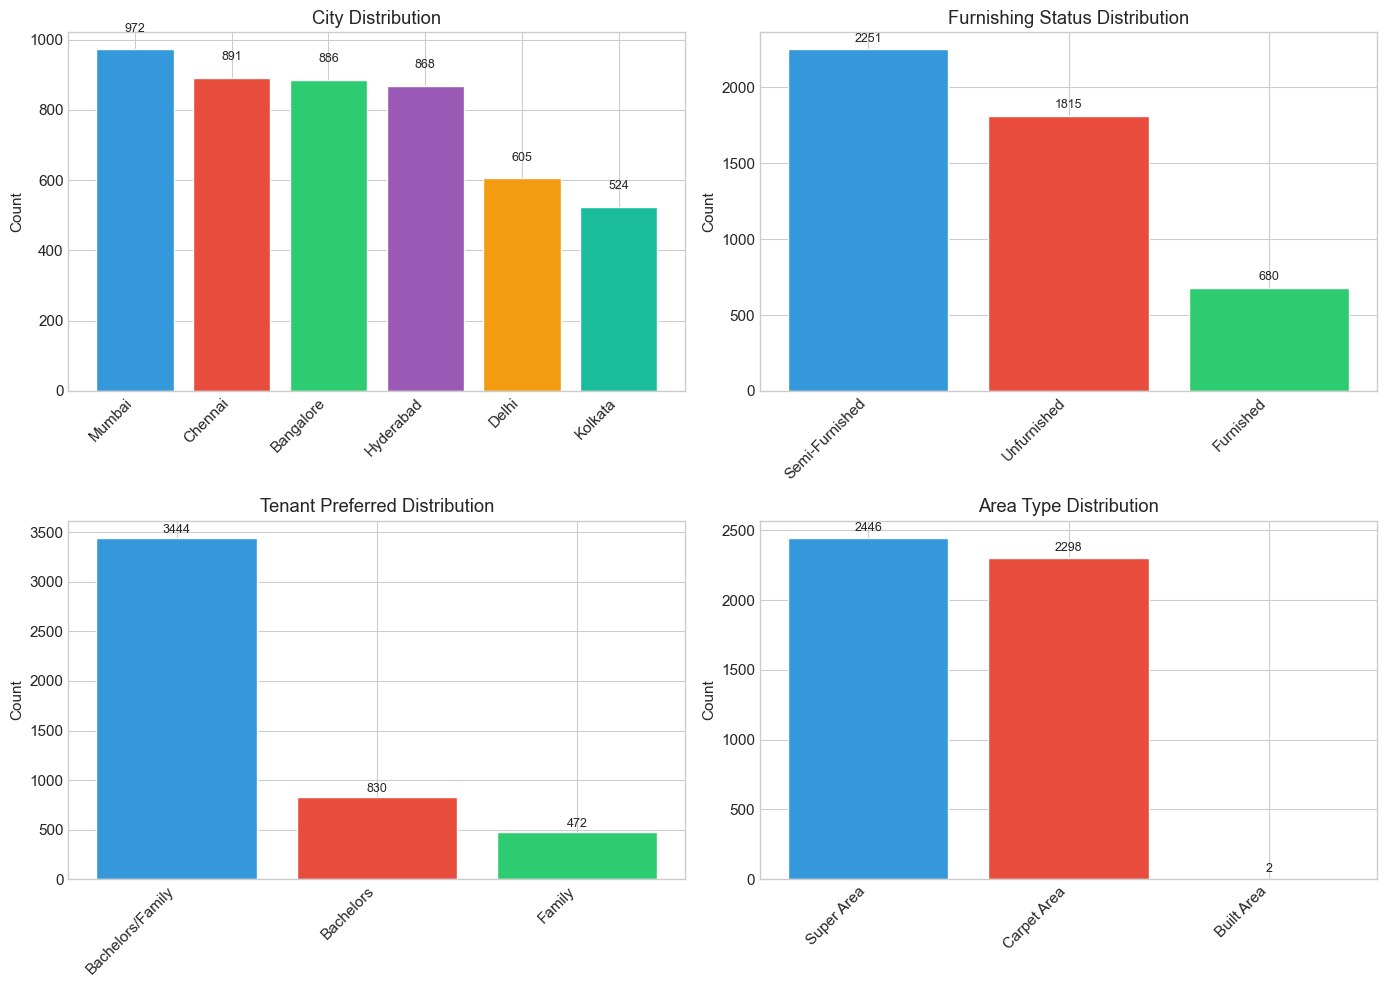

In [73]:
# Categorical features distribution
cat_features = ['City', 'Furnishing Status', 'Tenant Preferred', 'Area Type']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']

for i, col in enumerate(cat_features):
    value_counts = df_raw[col].value_counts()
    axes[i].bar(range(len(value_counts)), value_counts.values, color=colors[:len(value_counts)], edgecolor='white')
    axes[i].set_xticks(range(len(value_counts)))
    axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_ylabel('Count')
    
    # Add count labels
    for j, v in enumerate(value_counts.values):
        axes[i].text(j, v + 50, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()


### 1.3 Rent by City (Box Plot)


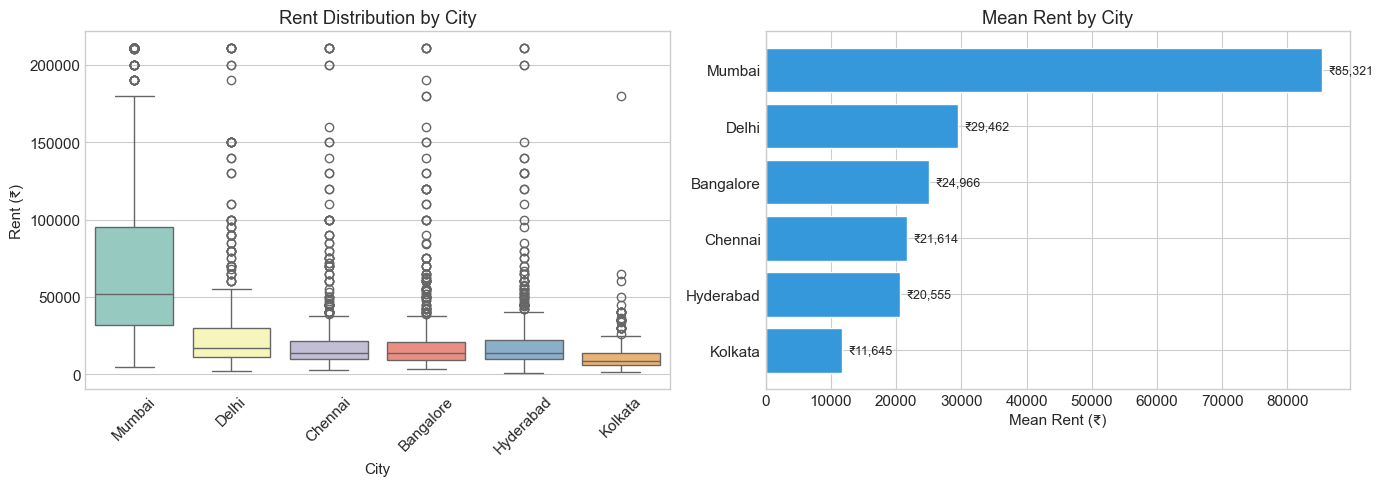

In [74]:
# Rent by City
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
city_order = df_raw.groupby('City')['Rent'].median().sort_values(ascending=False).index
upper = df_raw['Rent'].quantile(0.98)
df_plot = df_raw.copy()
df_plot['Rent_capped'] = df_plot['Rent'].clip(upper=upper)

sns.boxplot(
    data=df_plot,
    x='City',
    y='Rent_capped',
    order=city_order,
    ax=axes[0],
    palette='Set3'
)
axes[0].set_title('Rent Distribution by City')
axes[0].set_ylabel('Rent (₹)')
axes[0].tick_params(axis='x', rotation=45)

# Mean rent by city
city_means = df_raw.groupby('City')['Rent'].mean().sort_values(ascending=True)
axes[1].barh(city_means.index, city_means.values, color='#3498db', edgecolor='white')
axes[1].set_xlabel('Mean Rent (₹)')
axes[1].set_title('Mean Rent by City')

# Add value labels
for i, v in enumerate(city_means.values):
    axes[1].text(v + 1000, i, f'₹{v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


### 1.4 Size vs Rent Relationship


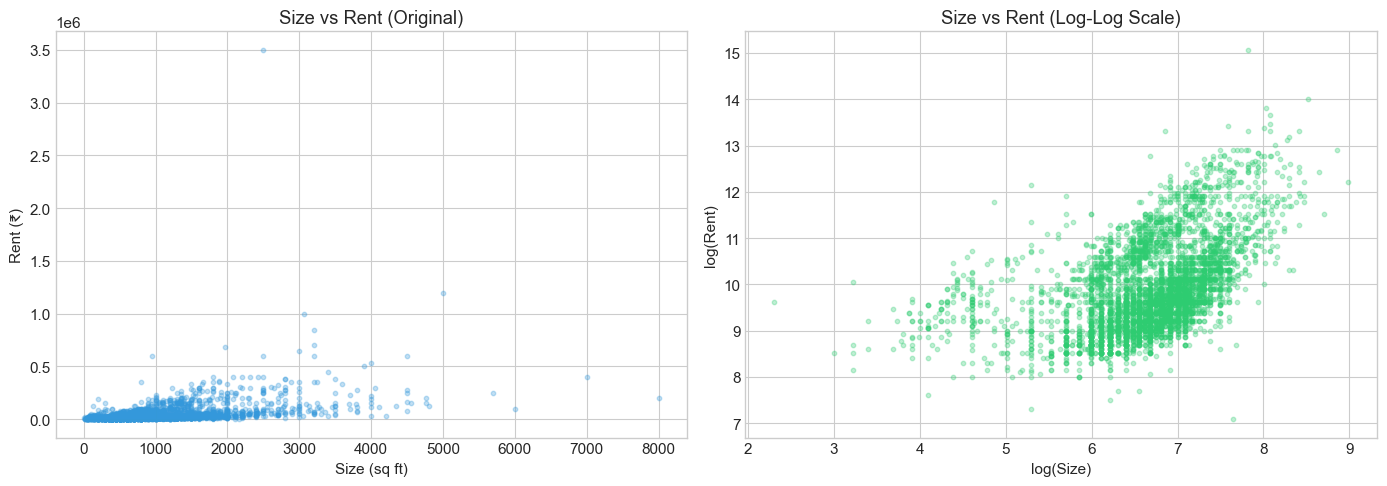

Correlation (Size, Rent): 0.4136
Correlation (log(Size), log(Rent)): 0.4862


In [75]:
# Size vs Rent scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original scale
axes[0].scatter(df_raw['Size'], df_raw['Rent'], alpha=0.3, c='#3498db', s=10)
axes[0].set_xlabel('Size (sq ft)')
axes[0].set_ylabel('Rent (₹)')
axes[0].set_title('Size vs Rent (Original)')

# Log-log scale
axes[1].scatter(np.log(df_raw['Size']), np.log(df_raw['Rent']), alpha=0.3, c='#2ecc71', s=10)
axes[1].set_xlabel('log(Size)')
axes[1].set_ylabel('log(Rent)')
axes[1].set_title('Size vs Rent (Log-Log Scale)')

plt.tight_layout()
plt.show()

print(f"Correlation (Size, Rent): {df_raw['Size'].corr(df_raw['Rent']):.4f}")
print(f"Correlation (log(Size), log(Rent)): {np.log(df_raw['Size']).corr(np.log(df_raw['Rent'])):.4f}")


### 1.5 Correlation Matrix


## 2. Data Preprocessing


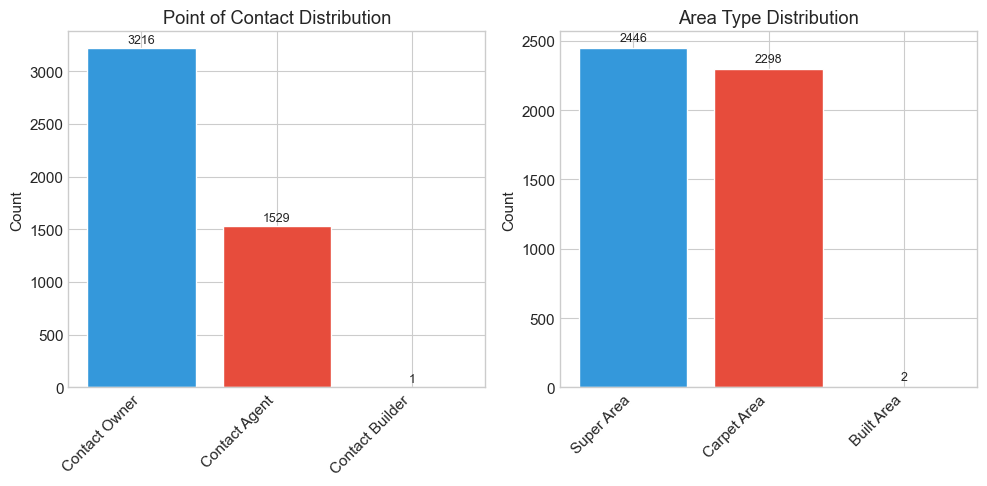

In [76]:
# Categorical features distribution
cat_features = ['Point of Contact', 'Area Type']


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']

for i, col in enumerate(cat_features):
    value_counts = df_raw[col].value_counts()
    axes[i].bar(range(len(value_counts)), value_counts.values, color=colors[:len(value_counts)], edgecolor='white')
    axes[i].set_xticks(range(len(value_counts)))
    axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_ylabel('Count')
    
    # Add count labels
    for j, v in enumerate(value_counts.values):
        axes[i].text(j, v + 50, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

Original dataset size: 4746
After 1-99 percentile filter (₹4,000 - ₹300,000): 4671
Dropped columns: ['Area Locality', 'Point of Contact', 'Area Type']
Remaining columns: ['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom']


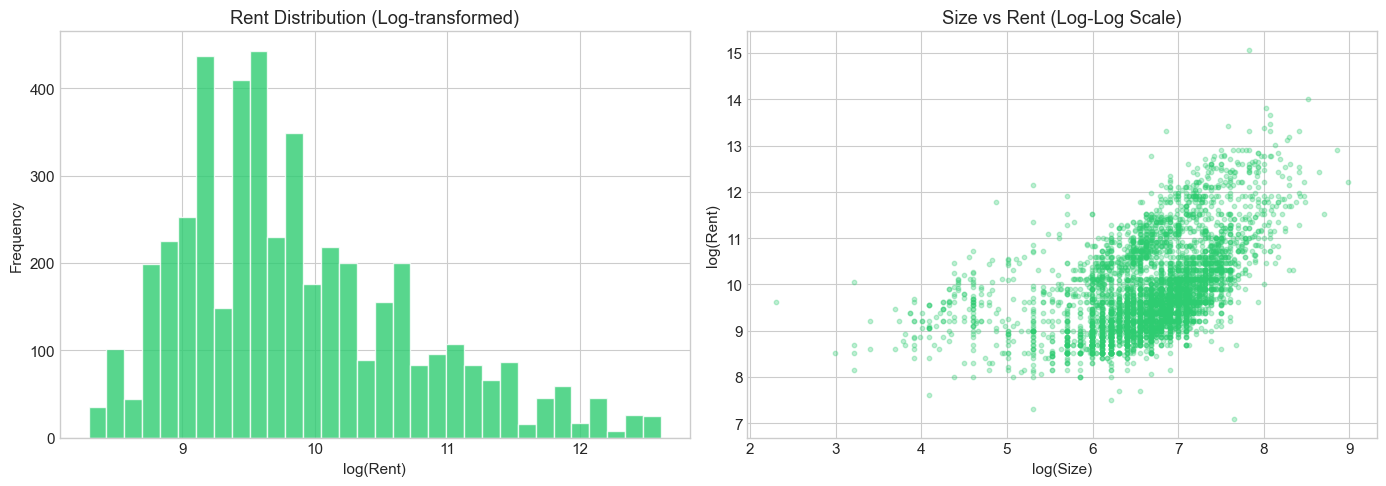

In [77]:
# Start with raw data copy
df = df_raw.copy()
print(f"Original dataset size: {len(df)}")

remove_part = 0.01
# Remove outliers using 1-99 percentiles
lower_bound = df['Rent'].quantile(remove_part)
upper_bound = df['Rent'].quantile(1 - remove_part)
df = df[(df['Rent'] >= lower_bound) & (df['Rent'] <= upper_bound)]
print(f"After {remove_part*100:.0f}-{(1-remove_part)*100:.0f} percentile filter (₹{lower_bound:,.0f} - ₹{upper_bound:,.0f}): {len(df)}")

# Drop unnecessary columns
columns_to_drop = ['Area Locality', 'Point of Contact', 'Area Type']
df = df.drop(columns=columns_to_drop)
print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining columns: {list(df.columns)}")

# Log-transformed distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(np.log(df['Rent']), bins="auto", color='#2ecc71', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('log(Rent)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Rent Distribution (Log-transformed)')
# Log-log scale
axes[1].scatter(np.log(df_raw['Size']), np.log(df_raw['Rent']), alpha=0.3, c='#2ecc71', s=10)
axes[1].set_xlabel('log(Size)')
axes[1].set_ylabel('log(Rent)')
axes[1].set_title('Size vs Rent (Log-Log Scale)')

plt.tight_layout()
plt.show()

### 2.1 Floor Column Parsing


In [78]:
# Parse Floor column: "2 out of 5" -> Floor Level = 2, Total Floors = 5
print("Sample Floor values:", df['Floor'].head(10).tolist())

def process_floor_column(df):
    """Parse Floor column into Floor Level and Total Floors."""
    df = df.copy()
    
    split_floor = df['Floor'].str.split(' out of ', expand=True)
    df['Floor Level'] = split_floor[0]
    df['Total Floors'] = split_floor[1]
    
    # Handle special floor names
    df['Floor Level'] = df['Floor Level'].replace({
        'Ground': 0,
        'Lower Basement': -1,
        'Upper Basement': -2
    })
    
    df['Floor Level'] = pd.to_numeric(df['Floor Level'], errors='coerce')
    df['Total Floors'] = pd.to_numeric(df['Total Floors'], errors='coerce')
    
    # Fill missing with median
    df['Floor Level'] = df['Floor Level'].fillna(df['Floor Level'].median())
    df['Total Floors'] = df['Total Floors'].fillna(df['Total Floors'].median())
    
    df = df.drop(['Floor'], axis=1)
    return df

df = process_floor_column(df)
print(f"\nAfter parsing Floor column:")
print(df[['Floor Level', 'Total Floors']].describe())


Sample Floor values: ['Ground out of 2', '1 out of 3', '1 out of 3', '1 out of 2', '1 out of 2', 'Ground out of 1', 'Ground out of 4', '1 out of 2', '1 out of 2', '1 out of 3']

After parsing Floor column:
       Floor Level  Total Floors
count  4671.000000   4671.000000
mean      3.368230      6.850567
std       5.606295      9.135357
min      -2.000000      1.000000
25%       1.000000      2.000000
50%       2.000000      4.000000
75%       3.000000      6.000000
max      76.000000     89.000000


### 2.2 Date Features Engineering


Date features created:
  day of week posted: [2 4 0 1 5 3 6]
  quarter posted: [2 3]


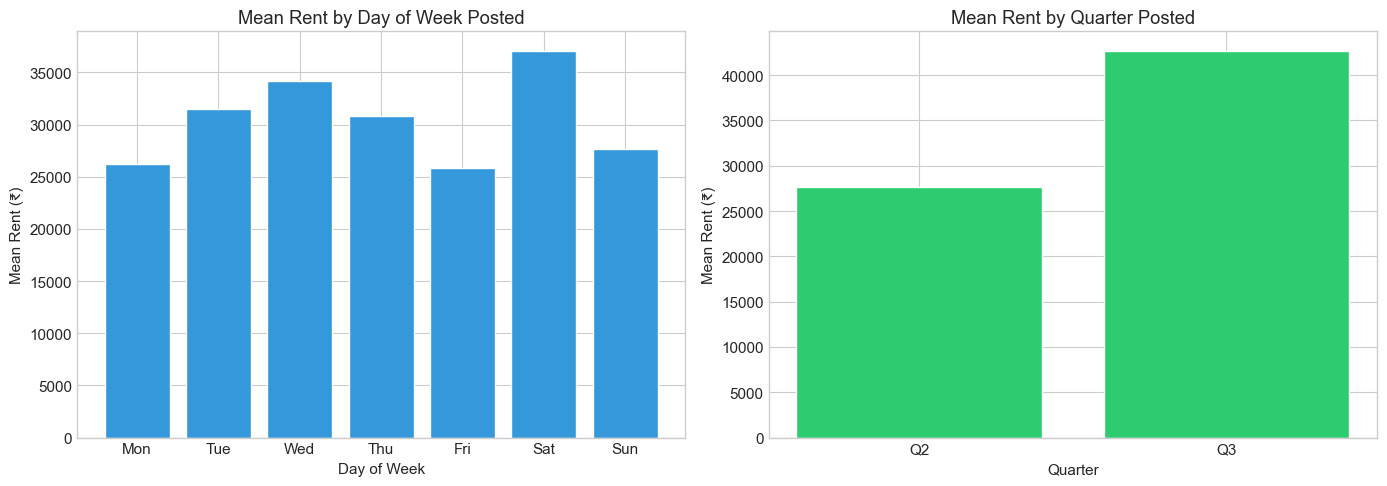

In [79]:
# Extract date features from Posted On
df['Posted On'] = pd.to_datetime(df['Posted On'])
df['day of week posted'] = df['Posted On'].dt.day_of_week
df['quarter posted'] = df['Posted On'].dt.quarter
df = df.drop('Posted On', axis=1)

print("Date features created:")
print(f"  day of week posted: {df['day of week posted'].unique()}")
print(f"  quarter posted: {df['quarter posted'].unique()}")

# Visualize date features vs rent
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Day of week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_means = df.groupby('day of week posted')['Rent'].mean()
axes[0].bar(day_names, day_means.values, color='#3498db', edgecolor='white')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Mean Rent (₹)')
axes[0].set_title('Mean Rent by Day of Week Posted')

# Quarter
quarter_means = df.groupby('quarter posted')['Rent'].mean()
axes[1].bar([f'Q{q}' for q in quarter_means.index], quarter_means.values, color='#2ecc71', edgecolor='white')
axes[1].set_xlabel('Quarter')
axes[1].set_ylabel('Mean Rent (₹)')
axes[1].set_title('Mean Rent by Quarter Posted')

plt.tight_layout()
plt.show()


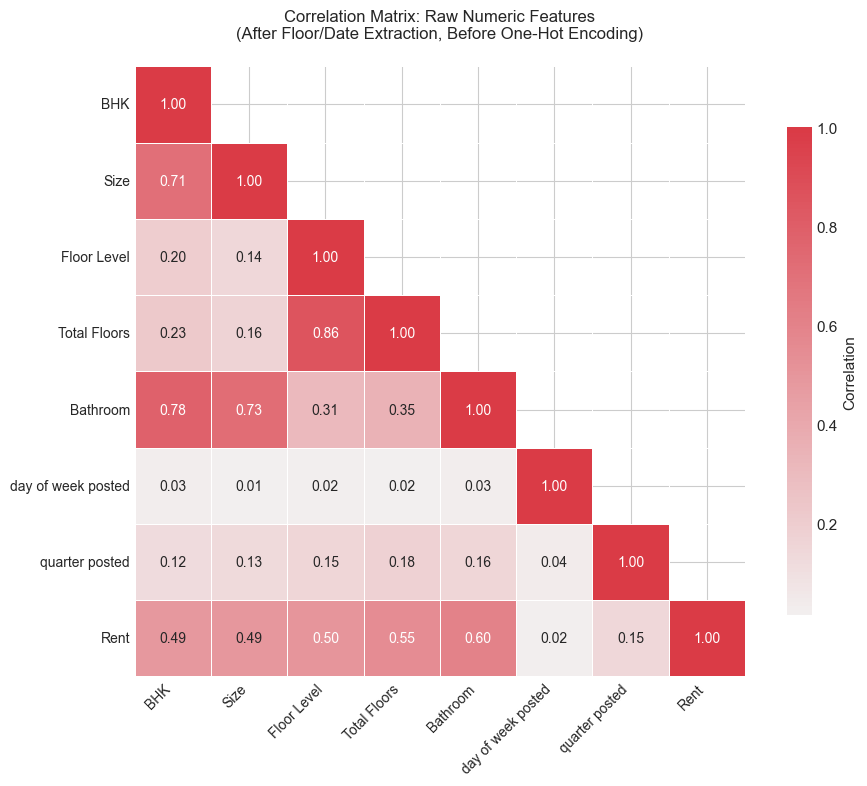


Top correlations with Rent:
  Bathroom: 0.6032
  Total Floors: 0.5505
  Floor Level: 0.5008
  Size: 0.4923
  BHK: 0.4883
  quarter posted: 0.1478
  day of week posted: 0.0193

Top feature-feature correlations:
  Floor Level ↔ Total Floors: 0.8562
  BHK ↔ Bathroom: 0.7832
  Size ↔ Bathroom: 0.7264
  BHK ↔ Size: 0.7062
  Total Floors ↔ Bathroom: 0.3465


In [80]:
# ============================================
# Correlation Matrix - Raw Numeric Features (Before One-Hot Encoding)
# ============================================
# Select only numeric columns for correlation analysis
numeric_cols_raw = ['BHK', 'Size', 'Floor Level', 'Total Floors', 'Bathroom', 
                    'day of week posted', 'quarter posted', 'Rent']

df_numeric = df[numeric_cols_raw].copy()

# Compute correlation matrix
corr_raw = df_numeric.corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(corr_raw, dtype=bool), k=1)
cmap = sns.diverging_palette(250, 10, as_cmap=True)

sns.heatmap(
    corr_raw,
    mask=mask,
    cmap=cmap,
    center=0,
    annot=True,
    fmt='.2f',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
    annot_kws={'size': 10},
    ax=ax
)

ax.set_title('Correlation Matrix: Raw Numeric Features\n(After Floor/Date Extraction, Before One-Hot Encoding)', 
             fontsize=12, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Print top correlations
print("\nTop correlations with Rent:")
rent_corr = corr_raw['Rent'].drop('Rent').sort_values(key=abs, ascending=False)
for feat, val in rent_corr.items():
    print(f"  {feat}: {val:.4f}")

print("\nTop feature-feature correlations:")
n = len(corr_raw.columns)
pairs = []
for i in range(n):
    for j in range(i + 1, n):
        if corr_raw.columns[i] != 'Rent' and corr_raw.columns[j] != 'Rent':
            pairs.append({
                'pair': f"{corr_raw.columns[i]} ↔ {corr_raw.columns[j]}",
                'corr': corr_raw.iat[i, j]
            })
top_pairs = sorted(pairs, key=lambda x: abs(x['corr']), reverse=True)[:5]
for p in top_pairs:
    print(f"  {p['pair']}: {p['corr']:.4f}")


## 3. Train/Test Split & Feature Engineering


In [81]:
# Train/Test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# Separate features and target
target_column = 'Rent'
X_train = train_df.drop(columns=[target_column])
y_train = np.log(train_df[target_column])  # Log transform target

X_test = test_df.drop(columns=[target_column])
y_test = np.log(test_df[target_column])

print(f"\nFeatures shape: {X_train.shape}")
print(f"Features: {list(X_train.columns)}")


Train size: 3736, Test size: 935

Features shape: (3736, 10)
Features: ['BHK', 'Size', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Floor Level', 'Total Floors', 'day of week posted', 'quarter posted']


### 3.1 Column Transformer (Log Scaling + One-Hot Encoding)


In [82]:
# ============================================
# Configuration from config.py
# ============================================
LOG_SCALING_COLS = ['Size']
NUMERIC_COLS = ['Floor Level', 'Total Floors', 'BHK', 'Bathroom']
CATEGORICAL_COLS = ['City', 'Furnishing Status', 'Tenant Preferred', 'day of week posted', 'quarter posted']

# Interaction combinations (empty = no combinations)
COMBINATIONS_TO_APPLY = [
    # {'columns': ['City', 'quarter posted', 'Tenant Preferred'], 'keep_originals': False},
]

# Pretty names for feature display
PRETTY_NAMES = {
    'day of week posted': {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun',
                          '0': 'Mon', '1': 'Tue', '2': 'Wed', '3': 'Thu', '4': 'Fri', '5': 'Sat', '6': 'Sun'},
    'quarter posted': {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4', '1': 'Q1', '2': 'Q2', '3': 'Q3', '4': 'Q4'}
}

COLUMN_SHORT_NAMES = {
    'day of week posted': 'Day',
    'quarter posted': 'Quarter',
    'Furnishing Status': 'Furnishing',
    'Tenant Preferred': 'Tenant',
}

def prettify_value(col_name, value):
    if col_name in PRETTY_NAMES:
        pretty = PRETTY_NAMES[col_name].get(value)
        if pretty:
            return pretty
    return str(value)

def prettify_col_name(col_name):
    return COLUMN_SHORT_NAMES.get(col_name, col_name)

# ============================================
# CombinedOneHotEncoder from combined_onehot_encoder.py
# ============================================
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import product

def joint_one_hot(X, sizes):
    N = X.shape[0]
    split_points = np.cumsum(sizes[:-1])
    groups = np.split(X, split_points, axis=1)
    indices = [np.argmax(g, axis=1) for g in groups]
    multipliers = np.cumprod(sizes[::-1])[::-1]
    multipliers = np.append(multipliers[1:], 1)
    joint_index = sum(idx * m for idx, m in zip(indices, multipliers))
    joint = np.zeros((N, np.prod(sizes)), dtype=int)
    joint[np.arange(N), joint_index] = 1
    return joint

class CombinedOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_indices, sizes, keep_originals=False):
        self.column_indices = column_indices
        self.sizes = sizes
        self.keep_originals = keep_originals
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = np.array(X)
        columns_to_combine = X[:, self.column_indices]
        combined = joint_one_hot(columns_to_combine, self.sizes)
        if self.keep_originals:
            result = np.hstack([X, combined])
        else:
            all_indices = set(range(X.shape[1]))
            indices_to_keep = sorted(all_indices - set(self.column_indices))
            X_remaining = X[:, indices_to_keep]
            result = np.hstack([X_remaining, combined])
        return result

# ============================================
# LogScaling transformer
# ============================================
class LogScaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.log(X)

# ============================================
# Build preprocessing pipeline
# ============================================
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("log_transform", LogScaling(), LOG_SCALING_COLS),
    ("num_pipeline", num_pipeline, NUMERIC_COLS),
    ("cat_pipelines", cat_pipeline, CATEGORICAL_COLS)
], remainder='passthrough')

# Fit and transform
X_train_arr = preprocessor.fit_transform(X_train)
X_test_arr = preprocessor.transform(X_test)
print(f"After preprocessing: {X_train_arr.shape}")

# ============================================
# Get one-hot groups for combinations
# ============================================
def get_onehot_groups(preprocessor, log_cols, num_cols, cat_cols):
    start_idx = len(log_cols) + len(num_cols)
    ohe = preprocessor.named_transformers_['cat_pipelines'].named_steps['one_hot_encoder']
    onehot_groups = {}
    for col_name, categories in zip(cat_cols, ohe.categories_):
        size = len(categories)
        onehot_groups[col_name] = {'start': start_idx, 'size': size}
        start_idx += size
    return onehot_groups

onehot_groups = get_onehot_groups(preprocessor, LOG_SCALING_COLS, NUMERIC_COLS, CATEGORICAL_COLS)
print(f"OneHot groups: {onehot_groups}")

# ============================================
# Apply combinations (if any)
# ============================================
combiners = []
combined_groups = {}

for combo_config in COMBINATIONS_TO_APPLY:
    combo = combo_config['columns']
    keep_originals = combo_config.get('keep_originals', False)
    
    indices = []
    sizes = []
    for group_name in combo:
        group = onehot_groups[group_name]
        indices.extend(range(group['start'], group['start'] + group['size']))
        sizes.append(group['size'])
    
    print(f"Combining: {combo}, sizes={sizes}, keep_originals={keep_originals}")
    combiner = CombinedOneHotEncoder(column_indices=indices, sizes=sizes, keep_originals=keep_originals)
    X_train_arr = combiner.fit_transform(X_train_arr)
    X_test_arr = combiner.transform(X_test_arr)
    combiners.append(combiner)
    
    combined_size = np.prod(sizes)
    combined_start = X_train_arr.shape[1] - combined_size
    combined_name = ' x '.join(combo)
    combined_groups[combined_name] = {'start': combined_start, 'size': combined_size}
    
    if not keep_originals:
        for group_name in combo:
            del onehot_groups[group_name]
        indices_set = set(indices)
        for name, group in onehot_groups.items():
            removed_before = sum(1 for idx in indices_set if idx < group['start'])
            group['start'] = group['start'] - removed_before
        for name, group in combined_groups.items():
            if name != combined_name:
                removed_before = sum(1 for idx in indices_set if idx < group['start'])
                group['start'] = group['start'] - removed_before
    
    print(f"After combining: shape={X_train_arr.shape}")

# ============================================
# Drop first column from each one-hot group (dummy variable trap)
# ============================================
all_groups = {**onehot_groups, **combined_groups}
columns_to_drop = [group['start'] for group in all_groups.values()]
columns_to_drop = sorted(columns_to_drop, reverse=True)

for col_idx in columns_to_drop:
    X_train_arr = np.delete(X_train_arr, col_idx, axis=1)
    X_test_arr = np.delete(X_test_arr, col_idx, axis=1)

print(f"After dropping first of each group: {X_train_arr.shape}")

# ============================================
# Generate feature names (with pretty names)
# ============================================
ohe = preprocessor.named_transformers_['cat_pipelines'].named_steps['one_hot_encoder']
cat_col_to_categories = dict(zip(CATEGORICAL_COLS, ohe.categories_))

feature_names = []
feature_names.extend([f'log({col})' for col in LOG_SCALING_COLS])
feature_names.extend(NUMERIC_COLS)

# Remaining one-hot groups
removed_cols = [item for combo_config in COMBINATIONS_TO_APPLY 
               for item in combo_config['columns'] 
               if not combo_config.get('keep_originals', False)]
remaining_cat_cols = [c for c in CATEGORICAL_COLS if c not in removed_cols]

for col in remaining_cat_cols:
    categories = cat_col_to_categories[col]
    short_col = prettify_col_name(col)
    for cat in categories[1:]:  # Skip first (dropped for dummy trap)
        pretty_val = prettify_value(col, cat)
        feature_names.append(f'{short_col}: {pretty_val}')

# Combined group names
for combo_config in COMBINATIONS_TO_APPLY:
    combo = combo_config['columns']
    combo_categories = [cat_col_to_categories[c] for c in combo]
    all_combos = list(product(*combo_categories))
    for combo_vals in all_combos[1:]:  # Skip first
        parts = []
        for c, v in zip(combo, combo_vals):
            short_col = prettify_col_name(c)
            pretty_val = prettify_value(c, v)
            parts.append(f'{short_col}={pretty_val}')
        feature_names.append(' & '.join(parts))

print(f"\nTotal features: {len(feature_names)}")
print(f"Feature names: {feature_names}")


After preprocessing: (3736, 26)
OneHot groups: {'City': {'start': 5, 'size': 6}, 'Furnishing Status': {'start': 11, 'size': 3}, 'Tenant Preferred': {'start': 14, 'size': 3}, 'day of week posted': {'start': 17, 'size': 7}, 'quarter posted': {'start': 24, 'size': 2}}
After dropping first of each group: (3736, 21)

Total features: 21
Feature names: ['log(Size)', 'Floor Level', 'Total Floors', 'BHK', 'Bathroom', 'City: Chennai', 'City: Delhi', 'City: Hyderabad', 'City: Kolkata', 'City: Mumbai', 'Furnishing: Semi-Furnished', 'Furnishing: Unfurnished', 'Tenant: Bachelors/Family', 'Tenant: Family', 'Day: Tue', 'Day: Wed', 'Day: Thu', 'Day: Fri', 'Day: Sat', 'Day: Sun', 'Quarter: Q3']


### 3.2 Feature-Engineered Data Preview

In [97]:
# Create DataFrame with feature names for display
X_train_df = pd.DataFrame(X_train_arr, columns=feature_names)
X_test_df = pd.DataFrame(X_test_arr, columns=feature_names)

print(f"Training set shape: {X_train_df.shape}")
print(f"Test set shape: {X_test_df.shape}")
print(f"\nFeature-engineered data (first 10 rows of test set):")
X_test_df.head(10)


Training set shape: (3736, 21)
Test set shape: (935, 21)

Feature-engineered data (first 10 rows of test set):


,log(Size),Floor Level,Total Floors,BHK,Bathroom,City: Chennai,City: Delhi,City: Hyderabad,City: Kolkata,City: Mumbai,...,Furnishing: Unfurnished,Tenant: Bachelors/Family,Tenant: Family,Day: Tue,Day: Wed,Day: Thu,Day: Fri,Day: Sat,Day: Sun,Quarter: Q3
0,6.396930,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6.396930,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,7.003065,4.0,4.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,4.219508,3.0,5.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.047517,5.0,6.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,7.313220,23.0,34.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6,6.856462,6.0,7.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,6.907755,2.0,5.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,7.130899,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,6.109248,6.0,12.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 4. Model Training & Evaluation


In [83]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_arr, y_train)

# Predictions (in log scale)
y_train_pred_log = model.predict(X_train_arr)
y_test_pred_log = model.predict(X_test_arr)

# Convert predictions back to original scale
y_train_pred = np.exp(y_train_pred_log)
y_test_pred = np.exp(y_test_pred_log)

# Actual rent (original scale)
y_train_actual = np.exp(y_train)
y_test_actual = np.exp(y_test)

# ============================================
# Calculate Metrics (as in your realization)
# ============================================

# R² (on log scale - what model optimizes)
r2_train = r2_score(y_train, y_train_pred_log)
r2_test = r2_score(y_test, y_test_pred_log)

# RMSE (on original scale)
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

# MAE (on original scale)
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
mae_test = mean_absolute_error(y_test_actual, y_test_pred)

# RMSPE (Root Mean Square Percentage Error)
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100

rmspe_train = rmspe(y_train_actual, y_train_pred)
rmspe_test = rmspe(y_test_actual, y_test_pred)

# MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_train = mape(y_train_actual, y_train_pred)
mape_test = mape(y_test_actual, y_test_pred)

# Print Results
print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)
print()
print(f"{'Metric':<20} {'Train':<15} {'Test':<15}")
print("-" * 50)
print(f"{'R²':<20} {r2_train:<15.4f} {r2_test:<15.4f}")
print(f"{'RMSE (₹)':<20} {rmse_train:<15,.0f} {rmse_test:<15,.0f}")
print(f"{'MAE (₹)':<20} {mae_train:<15,.0f} {mae_test:<15,.0f}")
print(f"{'RMSPE (%)':<20} {rmspe_train:<15.2f} {rmspe_test:<15.2f}")
print(f"{'MAPE (%)':<20} {mape_train:<15.2f} {mape_test:<15.2f}")


MODEL PERFORMANCE METRICS

Metric               Train           Test           
--------------------------------------------------
R²                   0.7776          0.7702         
RMSE (₹)             22,987          26,439         
MAE (₹)              10,498          11,517         
RMSPE (%)            48.91           48.87          
MAPE (%)             33.21           33.92          


### 4.1 Predictions vs Actual


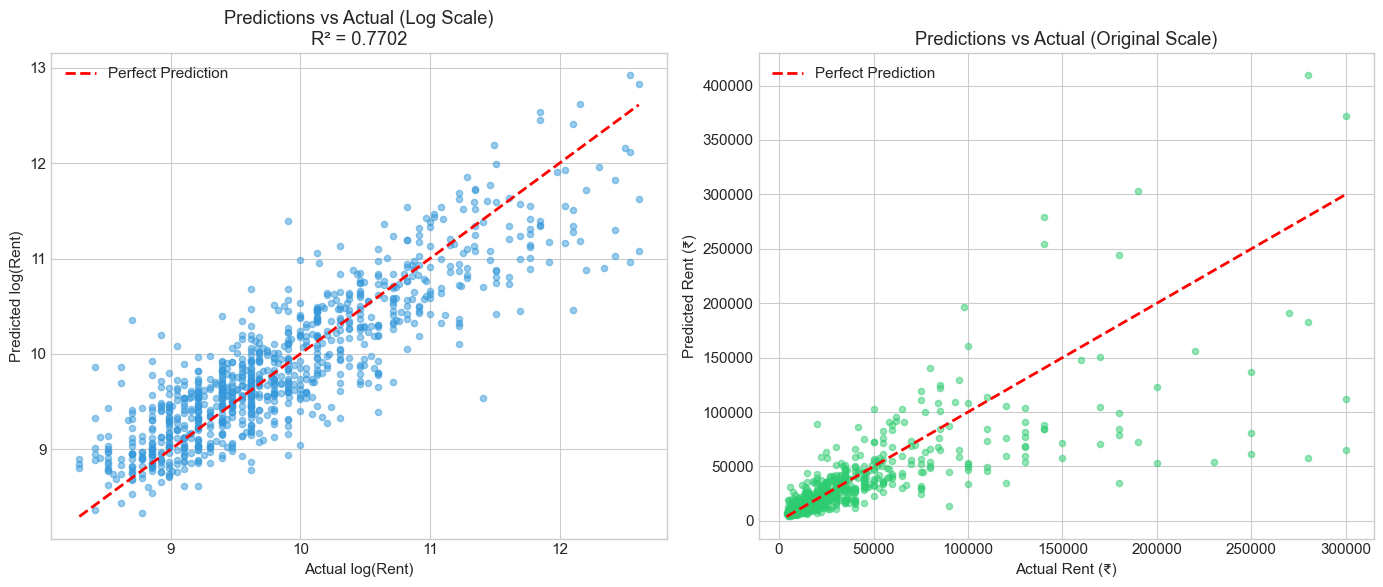

In [84]:
# Predictions vs Actual visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Log scale
axes[0].scatter(y_test, y_test_pred_log, alpha=0.5, c='#3498db', s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual log(Rent)')
axes[0].set_ylabel('Predicted log(Rent)')
axes[0].set_title(f'Predictions vs Actual (Log Scale)\nR² = {r2_test:.4f}')
axes[0].legend()

# Original scale
axes[1].scatter(y_test_actual, y_test_pred, alpha=0.5, c='#2ecc71', s=20)
axes[1].plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rent (₹)')
axes[1].set_ylabel('Predicted Rent (₹)')
axes[1].set_title('Predictions vs Actual (Original Scale)')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Feature Importance (Coefficients Analysis)


In [85]:
# Create coefficients dataframe
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_
})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print(f"Intercept: {model.intercept_:.4f}")
print(f"\nTop 15 Features by Absolute Coefficient:")
print(coef_df.head(15).to_string(index=False))


Intercept: 7.3686

Top 15 Features by Absolute Coefficient:
                   Feature  Coefficient  Abs_Coefficient
              City: Mumbai     1.004843         1.004843
   Furnishing: Unfurnished    -0.338045         0.338045
               City: Delhi     0.291882         0.291882
             City: Kolkata    -0.261648         0.261648
                       BHK     0.250332         0.250332
                  Bathroom     0.244729         0.244729
                 log(Size)     0.239991         0.239991
Furnishing: Semi-Furnished    -0.204698         0.204698
            Tenant: Family    -0.173787         0.173787
           City: Hyderabad    -0.156592         0.156592
  Tenant: Bachelors/Family    -0.140690         0.140690
               Quarter: Q3     0.080762         0.080762
             City: Chennai    -0.072122         0.072122
                  Day: Tue    -0.043536         0.043536
                  Day: Wed     0.018664         0.018664


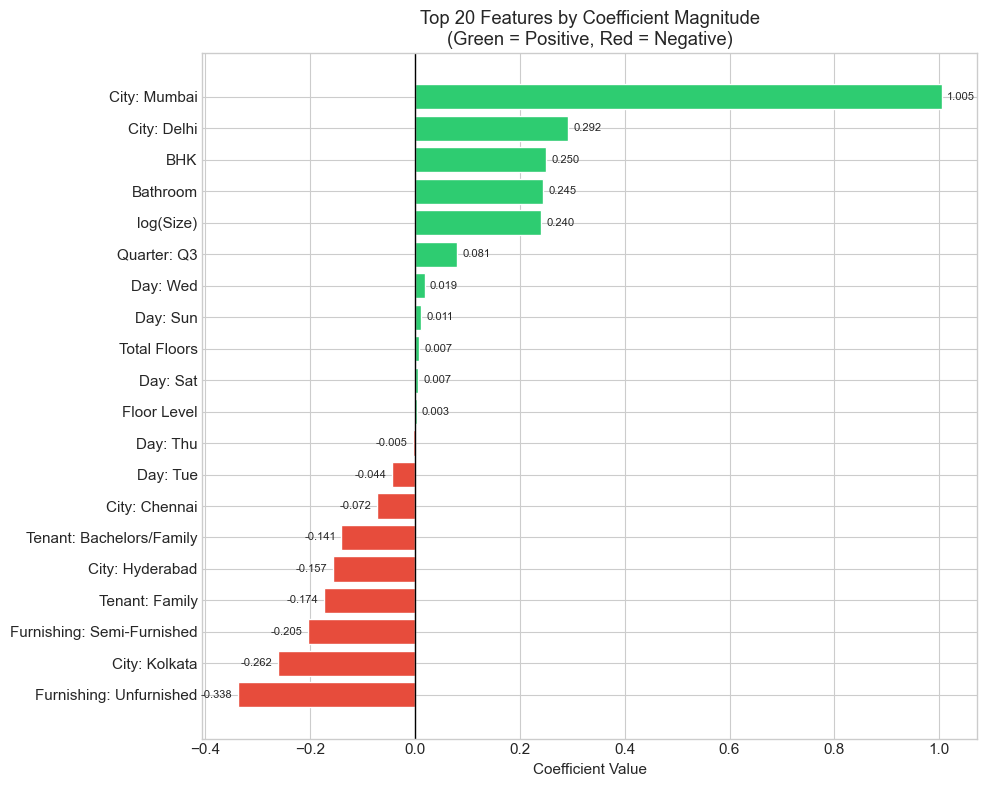

In [86]:
# Coefficient bar plot (Top 20)
top_n = 20
top_coefs = coef_df.head(top_n).sort_values('Coefficient')

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in top_coefs['Coefficient']]
bars = ax.barh(top_coefs['Feature'], top_coefs['Coefficient'], color=colors, edgecolor='white')

ax.axvline(x=0, color='black', linestyle='-', lw=1)
ax.set_xlabel('Coefficient Value')
ax.set_title(f'Top {top_n} Features by Coefficient Magnitude\n(Green = Positive, Red = Negative)')

# Add value labels
for bar, val in zip(bars, top_coefs['Coefficient']):
    x_pos = val + 0.01 if val >= 0 else val - 0.01
    ha = 'left' if val >= 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', ha=ha, fontsize=8)

plt.tight_layout()
plt.show()


### 5.1 Variance Inflation Factor (VIF) - Multicollinearity Check


In [87]:
# ============================================
# Variance Inflation Factor (VIF) - Multicollinearity Check
# For Model 1: Linear Regression (Basic)
# ============================================
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

print('=' * 90)
print('VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check')
print('Model: Linear Regression (Basic) - Model 1')
print('=' * 90)
print()
print('VIF > 5: Moderate multicollinearity')
print('VIF > 10: High multicollinearity (consider removing)')
print()

# Create DataFrame from X_train_arr with feature names
X_train_df = pd.DataFrame(X_train_arr, columns=feature_names)

print(f'Number of features: {X_train_df.shape[1]}')
print(f'Number of samples: {X_train_df.shape[0]}')
print()

X_for_vif = X_train_df.copy()

# Remove zero variance columns
zero_var_cols = X_for_vif.columns[X_for_vif.std() == 0].tolist()
if zero_var_cols:
    print(f'Columns with zero variance (excluded): {zero_var_cols}')
    X_for_vif = X_for_vif.drop(columns=zero_var_cols)
    print()

# Add constant for correct VIF calculation
X_vif_const = sm.add_constant(X_for_vif)

vif_data = []
for i, col in enumerate(X_for_vif.columns):
    try:
        vif = variance_inflation_factor(X_vif_const.values, i + 1)
        vif_data.append({'Feature': col, 'VIF': vif})
    except:
        vif_data.append({'Feature': col, 'VIF': np.nan})

vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

print(f'{"Feature":<35} {"VIF":>10} {"Status":>15}')
print('-' * 60)
for _, row in vif_df.iterrows():
    if pd.isna(row['VIF']) or np.isinf(row['VIF']):
        status = 'N/A'
    elif row['VIF'] > 10:
        status = 'HIGH!'
    elif row['VIF'] > 5:
        status = 'Moderate'
    else:
        status = 'OK'
    vif_val = f"{row['VIF']:.2f}" if not (pd.isna(row['VIF']) or np.isinf(row['VIF'])) else 'inf'
    print(f"{row['Feature']:<35} {vif_val:>10} {status:>15}")

# Summary
print()
high_vif = vif_df[vif_df['VIF'] > 10]
moderate_vif = vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)]
if len(high_vif) > 0:
    print(f'WARNING: {len(high_vif)} features with VIF > 10 (high multicollinearity)')
    for _, row in high_vif.iterrows():
        print(f'  - {row["Feature"]}: VIF = {row["VIF"]:.2f}')
else:
    print('OK: No features with VIF > 10')
if len(moderate_vif) > 0:
    print(f'NOTE: {len(moderate_vif)} features with VIF 5-10 (moderate multicollinearity)')


VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check
Model: Linear Regression (Basic) - Model 1

VIF > 5: Moderate multicollinearity
VIF > 10: High multicollinearity (consider removing)

Number of features: 21
Number of samples: 3736

Feature                                    VIF          Status
------------------------------------------------------------
Total Floors                              4.35              OK
Floor Level                               3.71              OK
Bathroom                                  3.27              OK
BHK                                       3.12              OK
Furnishing: Unfurnished                   2.43              OK
Furnishing: Semi-Furnished                2.41              OK
City: Mumbai                              2.33              OK
Day: Wed                                  2.00              OK
log(Size)                                 1.97              OK
Day: Thu                                  1.93              OK
Day: F

---

## 6. Model 2: Linear Regression with Feature Combinations

**Model 2** uses the same preprocessing pipeline but with feature interactions:
- Combines: City × Quarter × Tenant Preferred
- `keep_originals=False`: Replaces original columns with combined features


In [88]:
# ============================================
# Model 2: Preprocessing with Feature Combinations
# ============================================
print("=" * 80)
print("MODEL 2: Linear Regression with Feature Combinations")
print("=" * 80)
print()

# Configuration for Model 2 (with combinations)
COMBINATIONS_TO_APPLY_M2 = [
    {'columns': ['City', 'quarter posted', 'Tenant Preferred'], 'keep_originals': False},
]

# Build fresh preprocessor
num_pipeline_m2 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

cat_pipeline_m2 = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_m2 = ColumnTransformer([
    ("log_transform", LogScaling(), LOG_SCALING_COLS),
    ("num_pipeline", num_pipeline_m2, NUMERIC_COLS),
    ("cat_pipelines", cat_pipeline_m2, CATEGORICAL_COLS)
], remainder='passthrough')

# Fit and transform
X_train_arr_m2 = preprocessor_m2.fit_transform(X_train)
X_test_arr_m2 = preprocessor_m2.transform(X_test)
print(f"After preprocessing: {X_train_arr_m2.shape}")

# ============================================
# Get one-hot groups for combinations
# ============================================
onehot_groups_m2 = get_onehot_groups(preprocessor_m2, LOG_SCALING_COLS, NUMERIC_COLS, CATEGORICAL_COLS)
print(f"OneHot groups: {onehot_groups_m2}")

# ============================================
# Apply combinations
# ============================================
combiners_m2 = []
combined_groups_m2 = {}
onehot_groups_m2_copy = onehot_groups_m2.copy()

for combo_config in COMBINATIONS_TO_APPLY_M2:
    combo = combo_config['columns']
    keep_originals = combo_config.get('keep_originals', False)
    
    indices = []
    sizes = []
    for group_name in combo:
        group = onehot_groups_m2_copy[group_name]
        indices.extend(range(group['start'], group['start'] + group['size']))
        sizes.append(group['size'])
    
    print(f"Combining: {combo}, sizes={sizes}, keep_originals={keep_originals}")
    combiner = CombinedOneHotEncoder(column_indices=indices, sizes=sizes, keep_originals=keep_originals)
    X_train_arr_m2 = combiner.fit_transform(X_train_arr_m2)
    X_test_arr_m2 = combiner.transform(X_test_arr_m2)
    combiners_m2.append(combiner)
    
    combined_size = np.prod(sizes)
    combined_start = X_train_arr_m2.shape[1] - combined_size
    combined_name = ' x '.join(combo)
    combined_groups_m2[combined_name] = {'start': combined_start, 'size': combined_size}
    
    if not keep_originals:
        for group_name in combo:
            if group_name in onehot_groups_m2_copy:
                del onehot_groups_m2_copy[group_name]
        indices_set = set(indices)
        for name, group in onehot_groups_m2_copy.items():
            removed_before = sum(1 for idx in indices_set if idx < group['start'])
            group['start'] = group['start'] - removed_before
        for name, group in combined_groups_m2.items():
            if name != combined_name:
                removed_before = sum(1 for idx in indices_set if idx < group['start'])
                group['start'] = group['start'] - removed_before
    
    print(f"After combining: shape={X_train_arr_m2.shape}")

# ============================================
# Drop first column from each one-hot group (dummy variable trap)
# ============================================
all_groups_m2 = {**onehot_groups_m2_copy, **combined_groups_m2}
columns_to_drop_m2 = [group['start'] for group in all_groups_m2.values()]
columns_to_drop_m2 = sorted(columns_to_drop_m2, reverse=True)

for col_idx in columns_to_drop_m2:
    X_train_arr_m2 = np.delete(X_train_arr_m2, col_idx, axis=1)
    X_test_arr_m2 = np.delete(X_test_arr_m2, col_idx, axis=1)

print(f"After dropping first of each group: {X_train_arr_m2.shape}")

# ============================================
# Generate feature names for Model 2
# ============================================
ohe_m2 = preprocessor_m2.named_transformers_['cat_pipelines'].named_steps['one_hot_encoder']
cat_col_to_categories_m2 = dict(zip(CATEGORICAL_COLS, ohe_m2.categories_))

feature_names_m2 = []
feature_names_m2.extend([f'log({col})' for col in LOG_SCALING_COLS])
feature_names_m2.extend(NUMERIC_COLS)

# Remaining one-hot groups (not combined)
removed_cols_m2 = [item for combo_config in COMBINATIONS_TO_APPLY_M2 
                   for item in combo_config['columns'] 
                   if not combo_config.get('keep_originals', False)]
remaining_cat_cols_m2 = [c for c in CATEGORICAL_COLS if c not in removed_cols_m2]

for col in remaining_cat_cols_m2:
    categories = cat_col_to_categories_m2[col]
    short_col = prettify_col_name(col)
    for cat in categories[1:]:  # Skip first (dropped for dummy trap)
        pretty_val = prettify_value(col, cat)
        feature_names_m2.append(f'{short_col}: {pretty_val}')

# Combined group names
for combo_config in COMBINATIONS_TO_APPLY_M2:
    combo = combo_config['columns']
    combo_categories = [cat_col_to_categories_m2[c] for c in combo]
    all_combos = list(product(*combo_categories))
    for combo_vals in all_combos[1:]:  # Skip first
        parts = []
        for c, v in zip(combo, combo_vals):
            short_col = prettify_col_name(c)
            pretty_val = prettify_value(c, v)
            parts.append(f'{short_col}={pretty_val}')
        feature_names_m2.append(' & '.join(parts))

print(f"\nTotal features Model 2: {len(feature_names_m2)}")
print(f"Feature names: {feature_names_m2[:10]}... (showing first 10)")


MODEL 2: Linear Regression with Feature Combinations

After preprocessing: (3736, 26)
OneHot groups: {'City': {'start': 5, 'size': 6}, 'Furnishing Status': {'start': 11, 'size': 3}, 'Tenant Preferred': {'start': 14, 'size': 3}, 'day of week posted': {'start': 17, 'size': 7}, 'quarter posted': {'start': 24, 'size': 2}}
Combining: ['City', 'quarter posted', 'Tenant Preferred'], sizes=[6, 2, 3], keep_originals=False
After combining: shape=(3736, 51)
After dropping first of each group: (3736, 48)

Total features Model 2: 48
Feature names: ['log(Size)', 'Floor Level', 'Total Floors', 'BHK', 'Bathroom', 'Furnishing: Semi-Furnished', 'Furnishing: Unfurnished', 'Day: Tue', 'Day: Wed', 'Day: Thu']... (showing first 10)


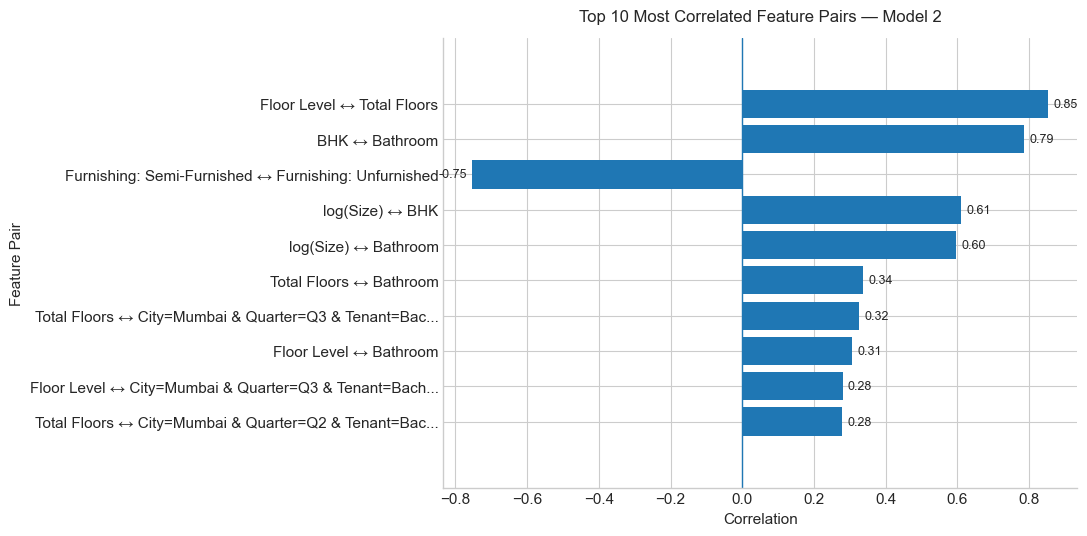


Model 2 correlation matrix shape: (48, 48)

Top correlated feature pairs (by absolute correlation):
1. Floor Level ↔ Total Floors: 0.8536
2. BHK ↔ Bathroom: 0.7851
3. Furnishing: Semi-Furnished ↔ Furnishing: Unfurnished: -0.7533
4. log(Size) ↔ BHK: 0.6107
5. log(Size) ↔ Bathroom: 0.5975
6. Total Floors ↔ Bathroom: 0.3365
7. Total Floors ↔ City=Mumbai & Quarter=Q3 & Tenant=Bachelors/Family: 0.3250
8. Floor Level ↔ Bathroom: 0.3060
9. Floor Level ↔ City=Mumbai & Quarter=Q3 & Tenant=Bachelors/Family: 0.2799
10. Total Floors ↔ City=Mumbai & Quarter=Q2 & Tenant=Bachelors/Family: 0.2785


In [89]:
# Build correlation matrix
X_train_df_m2 = pd.DataFrame(X_train_arr_m2, columns=feature_names_m2)
corr_matrix_m2 = X_train_df_m2.corr().fillna(0)

top_k = 10
cols = corr_matrix_m2.columns
n = len(cols)

# Collect upper triangle correlations
rows = []
for i in range(n):
    for j in range(i + 1, n):
        val = corr_matrix_m2.iat[i, j]
        rows.append({
            "pair": f"{cols[i]} ↔ {cols[j]}",
            "corr": val,
            "abs_corr": abs(val)
        })

top_df = (
    pd.DataFrame(rows)
    .sort_values("abs_corr", ascending=False)
    .head(top_k)
    .iloc[::-1]
)

# Truncate long feature-pair labels
def truncate(text, max_len=55):
    return text if len(text) <= max_len else text[:max_len - 3] + "..."

top_df["pair_short"] = top_df["pair"].apply(truncate)

# Dynamic figure height (prevents crowding)
fig_height = max(4, 0.55 * top_k)
fig, ax = plt.subplots(figsize=(11, fig_height))

bars = ax.barh(
    top_df["pair_short"],
    top_df["corr"]
)

# Improve spacing & readability
ax.margins(y=0.15)
ax.axvline(0, linewidth=1)

# Annotate correlation values (no overlap)
for bar, val in zip(bars, top_df["corr"]):
    x_offset = 0.015 * np.sign(val)
    ax.text(
        bar.get_width() + x_offset,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.2f}",
        va="center",
        ha="left" if val > 0 else "right",
        fontsize=9
    )

ax.set_title(
    f"Top {top_k} Most Correlated Feature Pairs — Model 2",
    fontsize=12,
    pad=12
)
ax.set_xlabel("Correlation")
ax.set_ylabel("Feature Pair")

# Remove visual clutter
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# Console summary (full names preserved)
print(f"\nModel 2 correlation matrix shape: {corr_matrix_m2.shape}")
print("\nTop correlated feature pairs (by absolute correlation):")
for i, row in enumerate(top_df.iloc[::-1].itertuples(), start=1):
    print(f"{i}. {row.pair}: {row.corr:.4f}")


In [90]:
# ============================================
# Train Linear Regression - Model 2
# ============================================
model_m2 = LinearRegression()
model_m2.fit(X_train_arr_m2, y_train.values)

# Predictions (log scale)
y_train_pred_log_m2 = model_m2.predict(X_train_arr_m2)
y_test_pred_log_m2 = model_m2.predict(X_test_arr_m2)

# Convert to original scale
y_train_pred_m2 = np.exp(y_train_pred_log_m2)
y_test_pred_m2 = np.exp(y_test_pred_log_m2)
y_train_actual_m2 = np.exp(y_train)
y_test_actual_m2 = np.exp(y_test)

# ============================================
# Calculate Metrics - Model 2
# ============================================

# R² (on log scale)
r2_train_m2 = r2_score(y_train, y_train_pred_log_m2)
r2_test_m2 = r2_score(y_test, y_test_pred_log_m2)

# RMSE (on original scale)
rmse_train_m2 = np.sqrt(mean_squared_error(y_train_actual_m2, y_train_pred_m2))
rmse_test_m2 = np.sqrt(mean_squared_error(y_test_actual_m2, y_test_pred_m2))

# MAE (on original scale)
mae_train_m2 = mean_absolute_error(y_train_actual_m2, y_train_pred_m2)
mae_test_m2 = mean_absolute_error(y_test_actual_m2, y_test_pred_m2)

# RMSPE
rmspe_train_m2 = rmspe(y_train_actual_m2, y_train_pred_m2)
rmspe_test_m2 = rmspe(y_test_actual_m2, y_test_pred_m2)

# MAPE
mape_train_m2 = mape(y_train_actual_m2, y_train_pred_m2)
mape_test_m2 = mape(y_test_actual_m2, y_test_pred_m2)

# Print Results
print("=" * 80)
print("MODEL 2 PERFORMANCE METRICS (City × Quarter × Tenant Combinations)")
print("=" * 80)
print()
print(f"{'Metric':<20} {'Train':<15} {'Test':<15}")
print("-" * 50)
print(f"{'R²':<20} {r2_train_m2:<15.4f} {r2_test_m2:<15.4f}")
print(f"{'RMSE (₹)':<20} {rmse_train_m2:<15,.0f} {rmse_test_m2:<15,.0f}")
print(f"{'MAE (₹)':<20} {mae_train_m2:<15,.0f} {mae_test_m2:<15,.0f}")
print(f"{'RMSPE (%)':<20} {rmspe_train_m2:<15.2f} {rmspe_test_m2:<15.2f}")
print(f"{'MAPE (%)':<20} {mape_train_m2:<15.2f} {mape_test_m2:<15.2f}")


MODEL 2 PERFORMANCE METRICS (City × Quarter × Tenant Combinations)

Metric               Train           Test           
--------------------------------------------------
R²                   0.7814          0.7663         
RMSE (₹)             23,077          27,126         
MAE (₹)              10,454          11,715         
RMSPE (%)            48.39           49.24          
MAPE (%)             32.96           34.18          


### 6.3 Predictions vs Actual - Model 2


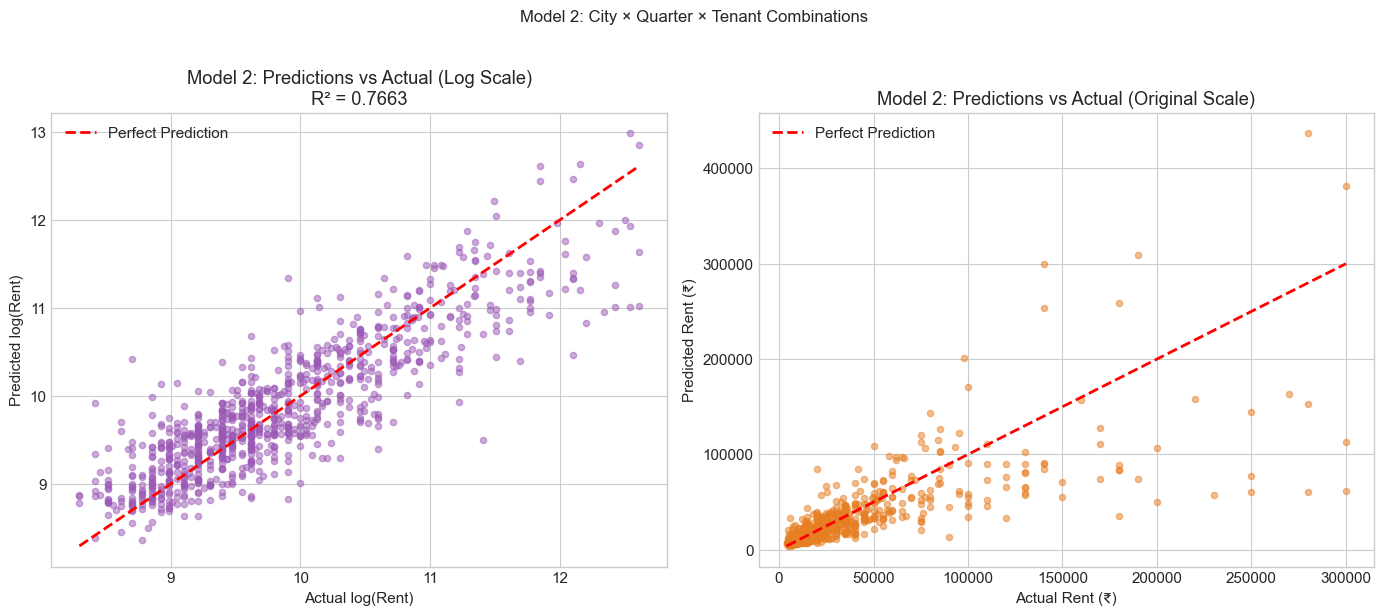

In [91]:
# Predictions vs Actual visualization - Model 2
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Log scale
axes[0].scatter(y_test, y_test_pred_log_m2, alpha=0.5, c='#9b59b6', s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual log(Rent)')
axes[0].set_ylabel('Predicted log(Rent)')
axes[0].set_title(f'Model 2: Predictions vs Actual (Log Scale)\nR² = {r2_test_m2:.4f}')
axes[0].legend()

# Original scale
axes[1].scatter(y_test_actual_m2, y_test_pred_m2, alpha=0.5, c='#e67e22', s=20)
axes[1].plot([y_test_actual_m2.min(), y_test_actual_m2.max()], [y_test_actual_m2.min(), y_test_actual_m2.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rent (₹)')
axes[1].set_ylabel('Predicted Rent (₹)')
axes[1].set_title('Model 2: Predictions vs Actual (Original Scale)')
axes[1].legend()

plt.suptitle('Model 2: City × Quarter × Tenant Combinations', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


Model 2 Intercept: 7.4181

Top 20 Features by Absolute Coefficient (Model 2):
                                              Feature  Coefficient  Abs_Coefficient
   City=Mumbai & Quarter=Q3 & Tenant=Bachelors/Family     0.942484         0.942484
          City=Mumbai & Quarter=Q3 & Tenant=Bachelors     0.942034         0.942034
          City=Mumbai & Quarter=Q2 & Tenant=Bachelors     0.935999         0.935999
   City=Mumbai & Quarter=Q2 & Tenant=Bachelors/Family     0.911337         0.911337
             City=Mumbai & Quarter=Q3 & Tenant=Family     0.887597         0.887597
             City=Mumbai & Quarter=Q2 & Tenant=Family     0.651351         0.651351
            City=Kolkata & Quarter=Q2 & Tenant=Family    -0.456090         0.456090
  City=Kolkata & Quarter=Q3 & Tenant=Bachelors/Family    -0.443448         0.443448
  City=Kolkata & Quarter=Q2 & Tenant=Bachelors/Family    -0.396078         0.396078
           City=Delhi & Quarter=Q3 & Tenant=Bachelors     0.386096         0.38609

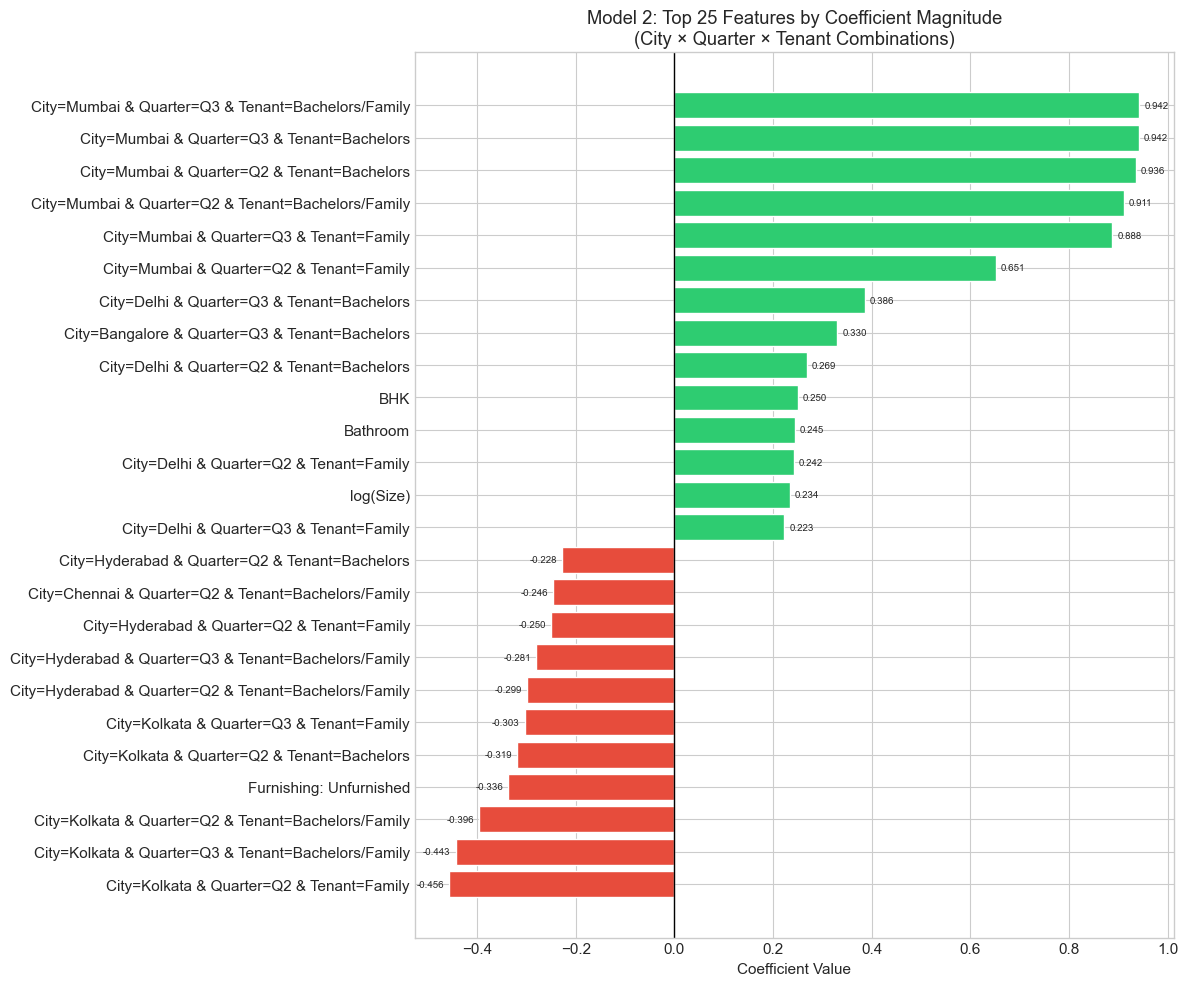

In [92]:
# Create coefficients dataframe - Model 2
coef_df_m2 = pd.DataFrame({
    'Feature': feature_names_m2,
    'Coefficient': model_m2.coef_
})
coef_df_m2['Abs_Coefficient'] = np.abs(coef_df_m2['Coefficient'])
coef_df_m2 = coef_df_m2.sort_values('Abs_Coefficient', ascending=False)

print(f"Model 2 Intercept: {model_m2.intercept_:.4f}")
print(f"\nTop 20 Features by Absolute Coefficient (Model 2):")
print(coef_df_m2.head(20).to_string(index=False))

# Coefficient bar plot - Model 2 (Top 25)
top_n_m2 = 25
top_coefs_m2 = coef_df_m2.head(top_n_m2).sort_values('Coefficient')

fig, ax = plt.subplots(figsize=(12, 10))

colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in top_coefs_m2['Coefficient']]
bars = ax.barh(top_coefs_m2['Feature'], top_coefs_m2['Coefficient'], color=colors, edgecolor='white')

ax.axvline(x=0, color='black', linestyle='-', lw=1)
ax.set_xlabel('Coefficient Value')
ax.set_title(f'Model 2: Top {top_n_m2} Features by Coefficient Magnitude\n(City × Quarter × Tenant Combinations)')

# Add value labels
for bar, val in zip(bars, top_coefs_m2['Coefficient']):
    x_pos = val + 0.01 if val >= 0 else val - 0.01
    ha = 'left' if val >= 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', ha=ha, fontsize=7)

plt.tight_layout()
plt.show()


In [93]:
### 6.5 Variance Inflation Factor (VIF) - Model 2


In [94]:
# ============================================
# Variance Inflation Factor (VIF) - Model 2
# ============================================
print('=' * 90)
print('VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check')
print('Model 2: Linear Regression with Feature Combinations (City × Quarter × Tenant)')
print('=' * 90)
print()
print('VIF > 5: Moderate multicollinearity')
print('VIF > 10: High multicollinearity (consider removing)')
print()

# Use the already created DataFrame
print(f'Number of features: {X_train_df_m2.shape[1]}')
print(f'Number of samples: {X_train_df_m2.shape[0]}')
print()

X_for_vif_m2 = X_train_df_m2.copy()

# Remove zero variance columns
zero_var_cols_m2 = X_for_vif_m2.columns[X_for_vif_m2.std() == 0].tolist()
if zero_var_cols_m2:
    print(f'Columns with zero variance (excluded): {zero_var_cols_m2}')
    X_for_vif_m2 = X_for_vif_m2.drop(columns=zero_var_cols_m2)
    print()

# Add constant for correct VIF calculation
X_vif_const_m2 = sm.add_constant(X_for_vif_m2)

vif_data_m2 = []
for i, col in enumerate(X_for_vif_m2.columns):
    try:
        vif = variance_inflation_factor(X_vif_const_m2.values, i + 1)
        vif_data_m2.append({'Feature': col, 'VIF': vif})
    except:
        vif_data_m2.append({'Feature': col, 'VIF': np.nan})

vif_df_m2 = pd.DataFrame(vif_data_m2).sort_values('VIF', ascending=False)

# Show top 30 features
print(f'{"Feature":<55} {"VIF":>10} {"Status":>15}')
print('-' * 80)
for _, row in vif_df_m2.head(30).iterrows():
    if pd.isna(row['VIF']) or np.isinf(row['VIF']):
        status = 'N/A'
    elif row['VIF'] > 10:
        status = 'HIGH!'
    elif row['VIF'] > 5:
        status = 'Moderate'
    else:
        status = 'OK'
    vif_val = f"{row['VIF']:.2f}" if not (pd.isna(row['VIF']) or np.isinf(row['VIF'])) else 'inf'
    print(f"{row['Feature']:<55} {vif_val:>10} {status:>15}")

# Summary
print()
high_vif_m2 = vif_df_m2[vif_df_m2['VIF'] > 10]
moderate_vif_m2 = vif_df_m2[(vif_df_m2['VIF'] > 5) & (vif_df_m2['VIF'] <= 10)]
if len(high_vif_m2) > 0:
    print(f'WARNING: {len(high_vif_m2)} features with VIF > 10 (high multicollinearity)')
else:
    print('OK: No features with VIF > 10')
if len(moderate_vif_m2) > 0:
    print(f'NOTE: {len(moderate_vif_m2)} features with VIF 5-10 (moderate multicollinearity)')


VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check
Model 2: Linear Regression with Feature Combinations (City × Quarter × Tenant)

VIF > 5: Moderate multicollinearity
VIF > 10: High multicollinearity (consider removing)

Number of features: 48
Number of samples: 3736

Feature                                                        VIF          Status
--------------------------------------------------------------------------------
City=Bangalore & Quarter=Q2 & Tenant=Bachelors/Family         5.51        Moderate
City=Hyderabad & Quarter=Q2 & Tenant=Bachelors/Family         4.99              OK
City=Chennai & Quarter=Q2 & Tenant=Bachelors/Family           4.99              OK
City=Mumbai & Quarter=Q2 & Tenant=Bachelors/Family            4.61              OK
Total Floors                                                  4.40              OK
City=Delhi & Quarter=Q2 & Tenant=Bachelors/Family             4.08              OK
Floor Level                                                   

---

## 7. Model Comparison: Model 1 vs Model 2

Compare the performance of both models:
- **Model 1**: Basic Linear Regression (no feature combinations)
- **Model 2**: Linear Regression with City × Quarter × Tenant combinations


MODEL COMPARISON: Model 1 (Basic) vs Model 2 (With Combinations)

         Metric Model 1 (Basic) Model 2 (Combinations)
     R² (Train)          0.7776                 0.7814
      R² (Test)          0.7702                 0.7663
 RMSE Train (₹)          22,987                 23,077
  RMSE Test (₹)          26,439                 27,126
  MAE Train (₹)          10,498                 10,454
   MAE Test (₹)          11,517                 11,715
RMSPE Train (%)           48.91                  48.39
 RMSPE Test (%)           48.87                  49.24
 MAPE Train (%)           33.21                  32.96
  MAPE Test (%)           33.92                  34.18
   Num Features              21                     48


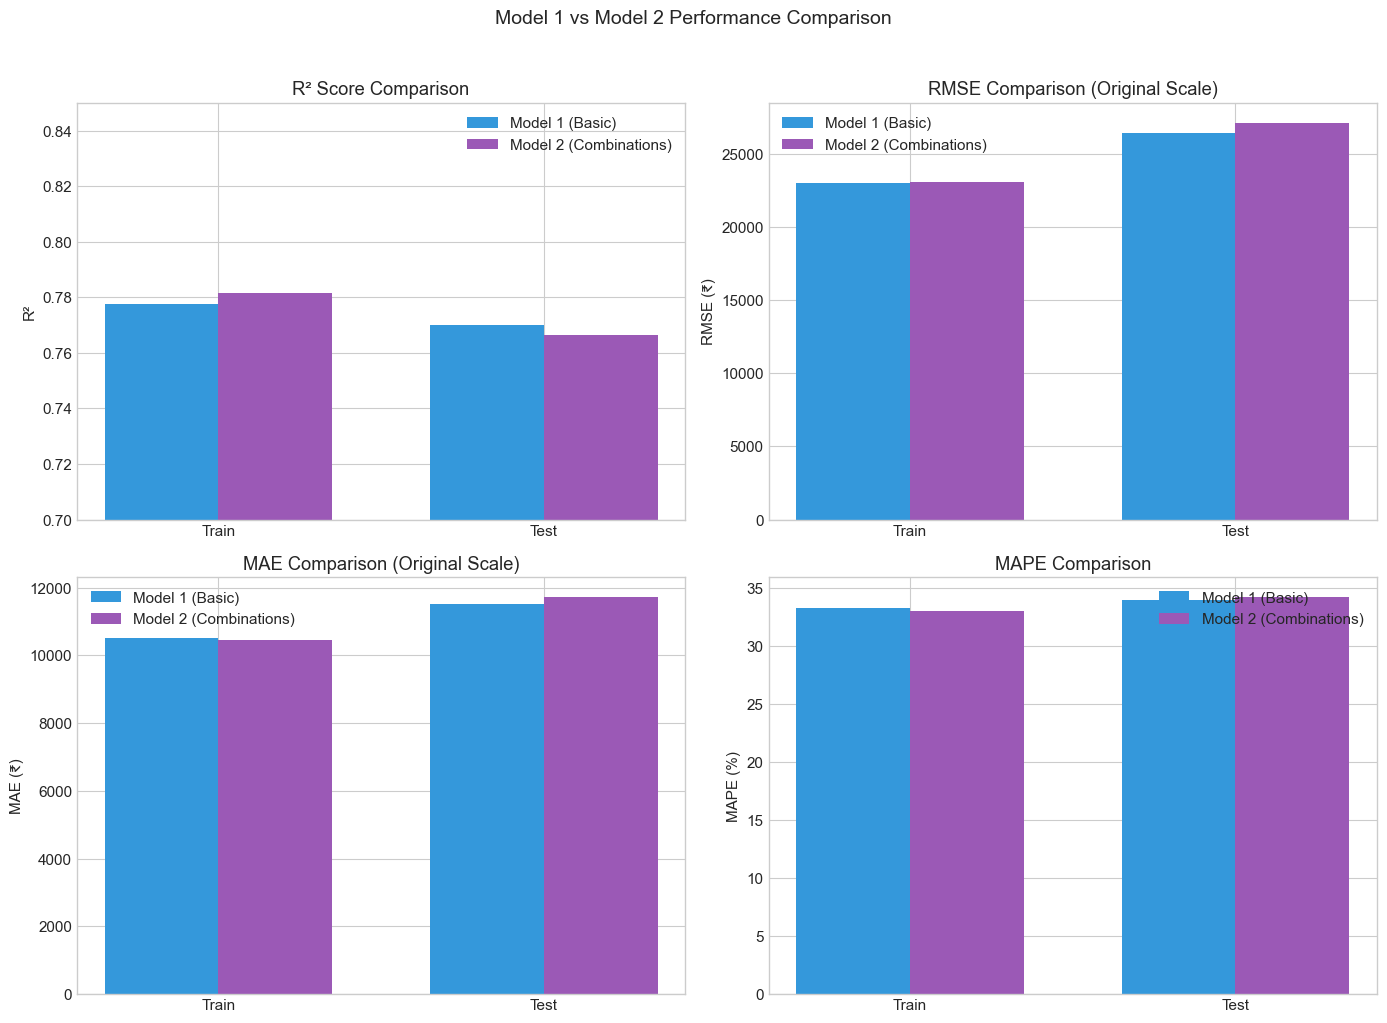


SUMMARY

Model 2 vs Model 1 (Test Set):
  R² difference: -0.0039 (worse)
  RMSE difference: +687 ₹ (worse)
  MAE difference: +199 ₹ (worse)

Model 1 features: 21
Model 2 features: 48


In [95]:
# ============================================
# Model Comparison Table
# ============================================
print("=" * 90)
print("MODEL COMPARISON: Model 1 (Basic) vs Model 2 (With Combinations)")
print("=" * 90)
print()

comparison_data = {
    'Metric': ['R² (Train)', 'R² (Test)', 'RMSE Train (₹)', 'RMSE Test (₹)', 
               'MAE Train (₹)', 'MAE Test (₹)', 'RMSPE Train (%)', 'RMSPE Test (%)',
               'MAPE Train (%)', 'MAPE Test (%)', 'Num Features'],
    'Model 1 (Basic)': [
        f'{r2_train:.4f}', f'{r2_test:.4f}', 
        f'{rmse_train:,.0f}', f'{rmse_test:,.0f}',
        f'{mae_train:,.0f}', f'{mae_test:,.0f}',
        f'{rmspe_train:.2f}', f'{rmspe_test:.2f}',
        f'{mape_train:.2f}', f'{mape_test:.2f}',
        f'{len(feature_names)}'
    ],
    'Model 2 (Combinations)': [
        f'{r2_train_m2:.4f}', f'{r2_test_m2:.4f}',
        f'{rmse_train_m2:,.0f}', f'{rmse_test_m2:,.0f}',
        f'{mae_train_m2:,.0f}', f'{mae_test_m2:,.0f}',
        f'{rmspe_train_m2:.2f}', f'{rmspe_test_m2:.2f}',
        f'{mape_train_m2:.2f}', f'{mape_test_m2:.2f}',
        f'{len(feature_names_m2)}'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Comparison chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R² comparison
metrics_r2 = ['Train', 'Test']
model1_r2 = [r2_train, r2_test]
model2_r2 = [r2_train_m2, r2_test_m2]

x = np.arange(len(metrics_r2))
width = 0.35

axes[0, 0].bar(x - width/2, model1_r2, width, label='Model 1 (Basic)', color='#3498db')
axes[0, 0].bar(x + width/2, model2_r2, width, label='Model 2 (Combinations)', color='#9b59b6')
axes[0, 0].set_ylabel('R²')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_r2)
axes[0, 0].legend()
axes[0, 0].set_ylim(0.7, 0.85)

# RMSE comparison
model1_rmse = [rmse_train, rmse_test]
model2_rmse = [rmse_train_m2, rmse_test_m2]

axes[0, 1].bar(x - width/2, model1_rmse, width, label='Model 1 (Basic)', color='#3498db')
axes[0, 1].bar(x + width/2, model2_rmse, width, label='Model 2 (Combinations)', color='#9b59b6')
axes[0, 1].set_ylabel('RMSE (₹)')
axes[0, 1].set_title('RMSE Comparison (Original Scale)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_r2)
axes[0, 1].legend()

# MAE comparison
model1_mae = [mae_train, mae_test]
model2_mae = [mae_train_m2, mae_test_m2]

axes[1, 0].bar(x - width/2, model1_mae, width, label='Model 1 (Basic)', color='#3498db')
axes[1, 0].bar(x + width/2, model2_mae, width, label='Model 2 (Combinations)', color='#9b59b6')
axes[1, 0].set_ylabel('MAE (₹)')
axes[1, 0].set_title('MAE Comparison (Original Scale)')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_r2)
axes[1, 0].legend()

# MAPE comparison
model1_mape = [mape_train, mape_test]
model2_mape = [mape_train_m2, mape_test_m2]

axes[1, 1].bar(x - width/2, model1_mape, width, label='Model 1 (Basic)', color='#3498db')
axes[1, 1].bar(x + width/2, model2_mape, width, label='Model 2 (Combinations)', color='#9b59b6')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].set_title('MAPE Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_r2)
axes[1, 1].legend()

plt.suptitle('Model 1 vs Model 2 Performance Comparison', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 90)
print("SUMMARY")
print("=" * 90)
r2_diff = r2_test_m2 - r2_test
rmse_diff = rmse_test_m2 - rmse_test
mae_diff = mae_test_m2 - mae_test

print(f"\nModel 2 vs Model 1 (Test Set):")
print(f"  R² difference: {r2_diff:+.4f} ({'better' if r2_diff > 0 else 'worse'})")
print(f"  RMSE difference: {rmse_diff:+,.0f} ₹ ({'worse' if rmse_diff > 0 else 'better'})")
print(f"  MAE difference: {mae_diff:+,.0f} ₹ ({'worse' if mae_diff > 0 else 'better'})")
print(f"\nModel 1 features: {len(feature_names)}")
print(f"Model 2 features: {len(feature_names_m2)}")


---

## 8. Model 3: XGBoost Regressor

**Model 3** uses XGBoost (Extreme Gradient Boosting) - a powerful ensemble method based on gradient boosted decision trees.
- Uses the same features as Model 1 (basic preprocessing without combinations)
- Non-linear model capable of capturing complex patterns


In [96]:
# ============================================
# Model 3: XGBoost Regressor
# ============================================
from xgboost import XGBRegressor

print("=" * 80)
print("MODEL 3: XGBoost Regressor")
print("=" * 80)
print()

# Train XGBoost (using same features as Model 1)
model_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train_arr, y_train.values)

# Predictions (log scale)
y_train_pred_log_xgb = model_xgb.predict(X_train_arr)
y_test_pred_log_xgb = model_xgb.predict(X_test_arr)

# Convert to original scale
y_train_pred_xgb = np.exp(y_train_pred_log_xgb)
y_test_pred_xgb = np.exp(y_test_pred_log_xgb)

# ============================================
# Calculate Metrics - Model 3 (XGBoost)
# ============================================

# R² (on log scale)
r2_train_xgb = r2_score(y_train, y_train_pred_log_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_log_xgb)

# RMSE (on original scale)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_xgb))

# MAE (on original scale)
mae_train_xgb = mean_absolute_error(y_train_actual, y_train_pred_xgb)
mae_test_xgb = mean_absolute_error(y_test_actual, y_test_pred_xgb)

# RMSPE
rmspe_train_xgb = rmspe(y_train_actual, y_train_pred_xgb)
rmspe_test_xgb = rmspe(y_test_actual, y_test_pred_xgb)

# MAPE
mape_train_xgb = mape(y_train_actual, y_train_pred_xgb)
mape_test_xgb = mape(y_test_actual, y_test_pred_xgb)

# Print Results
print(f"{'Metric':<20} {'Train':<15} {'Test':<15}")
print("-" * 50)
print(f"{'R²':<20} {r2_train_xgb:<15.4f} {r2_test_xgb:<15.4f}")
print(f"{'RMSE (₹)':<20} {rmse_train_xgb:<15,.0f} {rmse_test_xgb:<15,.0f}")
print(f"{'MAE (₹)':<20} {mae_train_xgb:<15,.0f} {mae_test_xgb:<15,.0f}")
print(f"{'RMSPE (%)':<20} {rmspe_train_xgb:<15.2f} {rmspe_test_xgb:<15.2f}")
print(f"{'MAPE (%)':<20} {mape_train_xgb:<15.2f} {mape_test_xgb:<15.2f}")


ModuleNotFoundError: No module named 'xgboost'


### 8.1 Predictions vs Actual - XGBoost

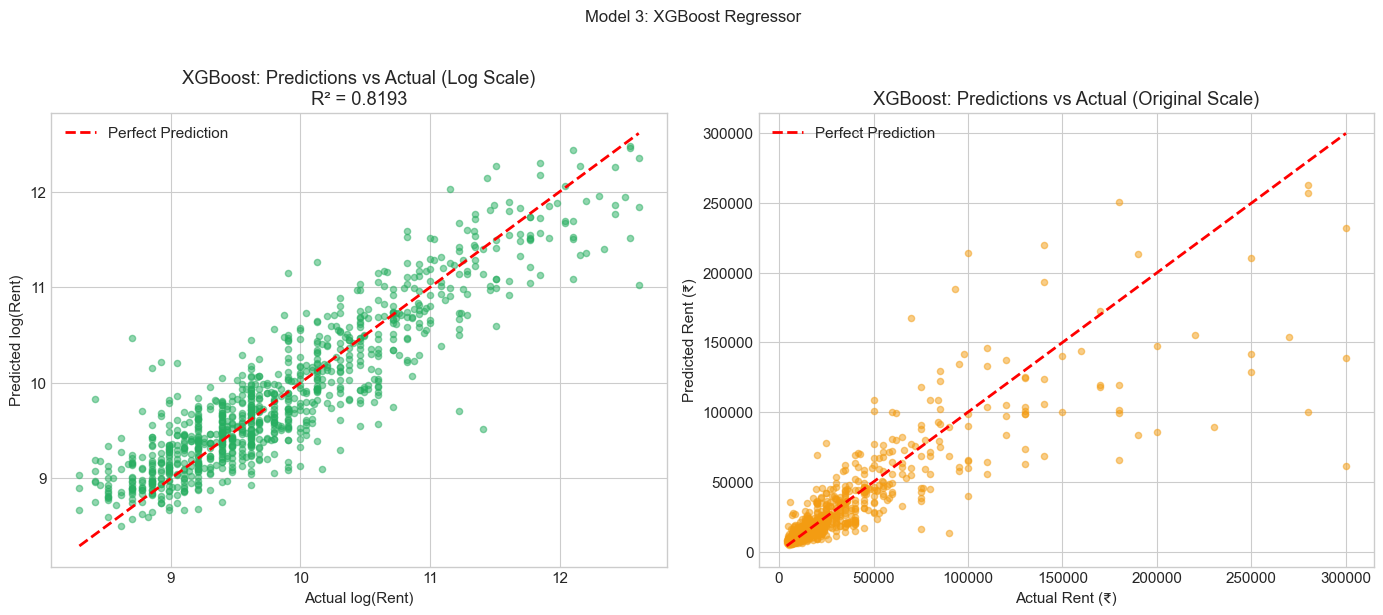

In [ ]:
# Predictions vs Actual visualization - XGBoost
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Log scale
axes[0].scatter(y_test, y_test_pred_log_xgb, alpha=0.5, c='#27ae60', s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual log(Rent)')
axes[0].set_ylabel('Predicted log(Rent)')
axes[0].set_title(f'XGBoost: Predictions vs Actual (Log Scale)\nR² = {r2_test_xgb:.4f}')
axes[0].legend()

# Original scale
axes[1].scatter(y_test_actual, y_test_pred_xgb, alpha=0.5, c='#f39c12', s=20)
axes[1].plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rent (₹)')
axes[1].set_ylabel('Predicted Rent (₹)')
axes[1].set_title('XGBoost: Predictions vs Actual (Original Scale)')
axes[1].legend()

plt.suptitle('Model 3: XGBoost Regressor', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


XGBoost Feature Importance (Top 20):
                   Feature  Importance
              City: Mumbai    0.499854
                  Bathroom    0.173047
              Total Floors    0.066733
                       BHK    0.061054
                 log(Size)    0.034082
               City: Delhi    0.031275
           City: Hyderabad    0.020978
             City: Kolkata    0.017634
   Furnishing: Unfurnished    0.014160
Furnishing: Semi-Furnished    0.009096
  Tenant: Bachelors/Family    0.007965
               Quarter: Q3    0.007341
             City: Chennai    0.007108
                  Day: Fri    0.007064
            Tenant: Family    0.006966
                  Day: Tue    0.006670
               Floor Level    0.006344
                  Day: Wed    0.006228
                  Day: Thu    0.006042
                  Day: Sun    0.005207


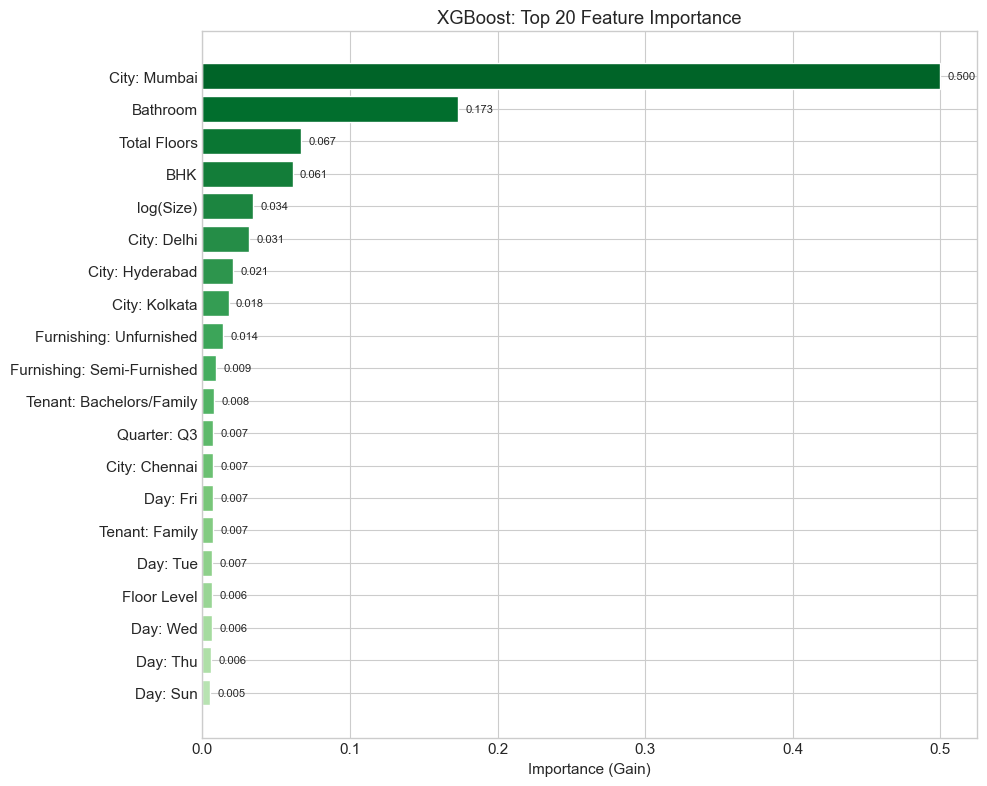

In [ ]:
# XGBoost Feature Importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print("XGBoost Feature Importance (Top 20):")
print(importance_df.head(20).to_string(index=False))

# Feature Importance bar plot
fig, ax = plt.subplots(figsize=(10, 8))

top_n_xgb = 20
top_importance = importance_df.head(top_n_xgb).sort_values('Importance')

colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(top_importance)))
bars = ax.barh(top_importance['Feature'], top_importance['Importance'], color=colors, edgecolor='white')

ax.set_xlabel('Importance (Gain)')
ax.set_title(f'XGBoost: Top {top_n_xgb} Feature Importance')

# Add value labels
for bar, val in zip(bars, top_importance['Importance']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()



---

## 9. Final Model Comparison: All 3 Models

Compare the performance of all three models:
- **Model 1**: Basic Linear Regression (21 features)
- **Model 2**: Linear Regression with City × Quarter × Tenant combinations (48 features)
- **Model 3**: XGBoost Regressor (21 features)

FINAL MODEL COMPARISON: All 3 Models

         Metric Model 1 (LR Basic) Model 2 (LR Combos) Model 3 (XGBoost)
     R² (Train)             0.7776              0.7814            0.9065
      R² (Test)             0.7702              0.7663            0.8193
 RMSE Train (₹)             22,987              23,077            12,048
  RMSE Test (₹)             26,439              27,126            21,365
  MAE Train (₹)             10,498              10,454             5,915
   MAE Test (₹)             11,517              11,715             9,480
RMSPE Train (%)              48.91               48.39             28.20
 RMSPE Test (%)              48.87               49.24             45.29
 MAPE Train (%)              33.21               32.96             21.09
  MAPE Test (%)              33.92               34.18             30.25
   Num Features                 21                  48                21
     Model Type             Linear              Linear        Tree-based


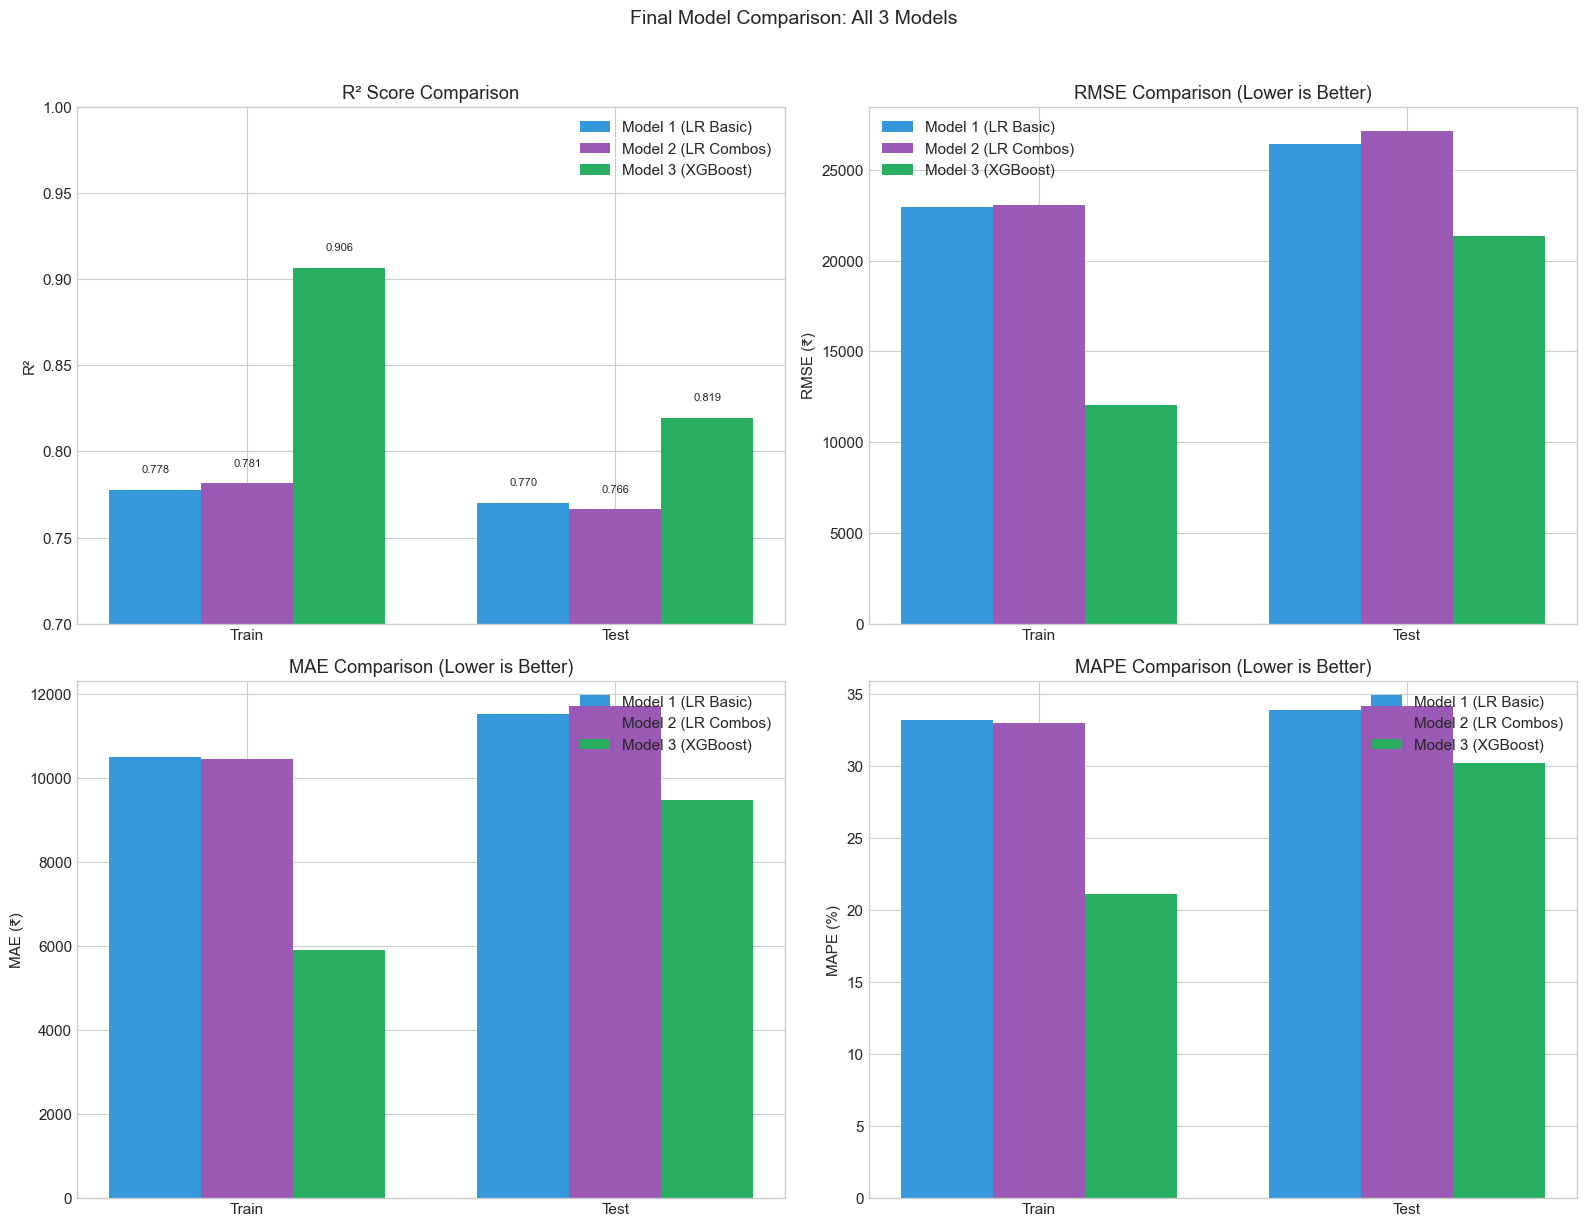

In [ ]:
# ============================================
# Final Model Comparison - All 3 Models
# ============================================
print("=" * 100)
print("FINAL MODEL COMPARISON: All 3 Models")
print("=" * 100)
print()

comparison_data_final = {
    'Metric': ['R² (Train)', 'R² (Test)', 'RMSE Train (₹)', 'RMSE Test (₹)', 
               'MAE Train (₹)', 'MAE Test (₹)', 'RMSPE Train (%)', 'RMSPE Test (%)',
               'MAPE Train (%)', 'MAPE Test (%)', 'Num Features', 'Model Type'],
    'Model 1 (LR Basic)': [
        f'{r2_train:.4f}', f'{r2_test:.4f}', 
        f'{rmse_train:,.0f}', f'{rmse_test:,.0f}',
        f'{mae_train:,.0f}', f'{mae_test:,.0f}',
        f'{rmspe_train:.2f}', f'{rmspe_test:.2f}',
        f'{mape_train:.2f}', f'{mape_test:.2f}',
        f'{len(feature_names)}', 'Linear'
    ],
    'Model 2 (LR Combos)': [
        f'{r2_train_m2:.4f}', f'{r2_test_m2:.4f}',
        f'{rmse_train_m2:,.0f}', f'{rmse_test_m2:,.0f}',
        f'{mae_train_m2:,.0f}', f'{mae_test_m2:,.0f}',
        f'{rmspe_train_m2:.2f}', f'{rmspe_test_m2:.2f}',
        f'{mape_train_m2:.2f}', f'{mape_test_m2:.2f}',
        f'{len(feature_names_m2)}', 'Linear'
    ],
    'Model 3 (XGBoost)': [
        f'{r2_train_xgb:.4f}', f'{r2_test_xgb:.4f}',
        f'{rmse_train_xgb:,.0f}', f'{rmse_test_xgb:,.0f}',
        f'{mae_train_xgb:,.0f}', f'{mae_test_xgb:,.0f}',
        f'{rmspe_train_xgb:.2f}', f'{rmspe_test_xgb:.2f}',
        f'{mape_train_xgb:.2f}', f'{mape_test_xgb:.2f}',
        f'{len(feature_names)}', 'Tree-based'
    ]
}

comparison_df_final = pd.DataFrame(comparison_data_final)
print(comparison_df_final.to_string(index=False))

# ============================================
# Comparison Charts
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_labels = ['Train', 'Test']
x = np.arange(len(metrics_labels))
width = 0.25

# Colors for 3 models
colors = ['#3498db', '#9b59b6', '#27ae60']

# R² comparison
model1_r2 = [r2_train, r2_test]
model2_r2 = [r2_train_m2, r2_test_m2]
model3_r2 = [r2_train_xgb, r2_test_xgb]

axes[0, 0].bar(x - width, model1_r2, width, label='Model 1 (LR Basic)', color=colors[0])
axes[0, 0].bar(x, model2_r2, width, label='Model 2 (LR Combos)', color=colors[1])
axes[0, 0].bar(x + width, model3_r2, width, label='Model 3 (XGBoost)', color=colors[2])
axes[0, 0].set_ylabel('R²')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_labels)
axes[0, 0].legend()
axes[0, 0].set_ylim(0.7, 1.0)

# Add value labels
for i, (m1, m2, m3) in enumerate(zip(model1_r2, model2_r2, model3_r2)):
    axes[0, 0].text(i - width, m1 + 0.01, f'{m1:.3f}', ha='center', fontsize=8)
    axes[0, 0].text(i, m2 + 0.01, f'{m2:.3f}', ha='center', fontsize=8)
    axes[0, 0].text(i + width, m3 + 0.01, f'{m3:.3f}', ha='center', fontsize=8)

# RMSE comparison
model1_rmse = [rmse_train, rmse_test]
model2_rmse = [rmse_train_m2, rmse_test_m2]
model3_rmse = [rmse_train_xgb, rmse_test_xgb]

axes[0, 1].bar(x - width, model1_rmse, width, label='Model 1 (LR Basic)', color=colors[0])
axes[0, 1].bar(x, model2_rmse, width, label='Model 2 (LR Combos)', color=colors[1])
axes[0, 1].bar(x + width, model3_rmse, width, label='Model 3 (XGBoost)', color=colors[2])
axes[0, 1].set_ylabel('RMSE (₹)')
axes[0, 1].set_title('RMSE Comparison (Lower is Better)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_labels)
axes[0, 1].legend()

# MAE comparison
model1_mae = [mae_train, mae_test]
model2_mae = [mae_train_m2, mae_test_m2]
model3_mae = [mae_train_xgb, mae_test_xgb]

axes[1, 0].bar(x - width, model1_mae, width, label='Model 1 (LR Basic)', color=colors[0])
axes[1, 0].bar(x, model2_mae, width, label='Model 2 (LR Combos)', color=colors[1])
axes[1, 0].bar(x + width, model3_mae, width, label='Model 3 (XGBoost)', color=colors[2])
axes[1, 0].set_ylabel('MAE (₹)')
axes[1, 0].set_title('MAE Comparison (Lower is Better)')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_labels)
axes[1, 0].legend()

# MAPE comparison
model1_mape = [mape_train, mape_test]
model2_mape = [mape_train_m2, mape_test_m2]
model3_mape = [mape_train_xgb, mape_test_xgb]

axes[1, 1].bar(x - width, model1_mape, width, label='Model 1 (LR Basic)', color=colors[0])
axes[1, 1].bar(x, model2_mape, width, label='Model 2 (LR Combos)', color=colors[1])
axes[1, 1].bar(x + width, model3_mape, width, label='Model 3 (XGBoost)', color=colors[2])
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].set_title('MAPE Comparison (Lower is Better)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_labels)
axes[1, 1].legend()

plt.suptitle('Final Model Comparison: All 3 Models', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()